In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras as keras
import tensorflow as tf
import keras.backend as K

%matplotlib inline
from datetime import datetime
from statsmodels.tools.eval_measures import rmse
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed, Masking, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
import io
import math
warnings.filterwarnings("ignore")

# Investigate Dataset

### Plot Raw Data

In [27]:
# Get the current working directory
current_directory = os.getcwd()
# Go one step up from the current directory
parent_directory = os.path.dirname(current_directory)
print(parent_directory)
# Enter another directory inside the parent directory
target_directory = os.path.join(parent_directory, 'dataset', 'Ohio2018_processed', 'train')
print(target_directory)
# Check if the target directory exists
if os.path.exists(target_directory) and os.path.isdir(target_directory):
    print("The target directory exists.")
else:
    print("The target directory does not exist.")

C:\Users\julia\Desktop\Studium_MA5\DataDrivenDiabetesManagement\Project\git\DataDrivenDiabetesSemesterProject
C:\Users\julia\Desktop\Studium_MA5\DataDrivenDiabetesManagement\Project\git\DataDrivenDiabetesSemesterProject\dataset\Ohio2018_processed\train
The target directory exists.


In [28]:
# Enter file name 
file_name= "563-ws-training_processed.csv"
file_path = os.path.join(target_directory, file_name)
print(file_path)

C:\Users\julia\Desktop\Studium_MA5\DataDrivenDiabetesManagement\Project\git\DataDrivenDiabetesSemesterProject\dataset\Ohio2018_processed\train\563-ws-training_processed.csv


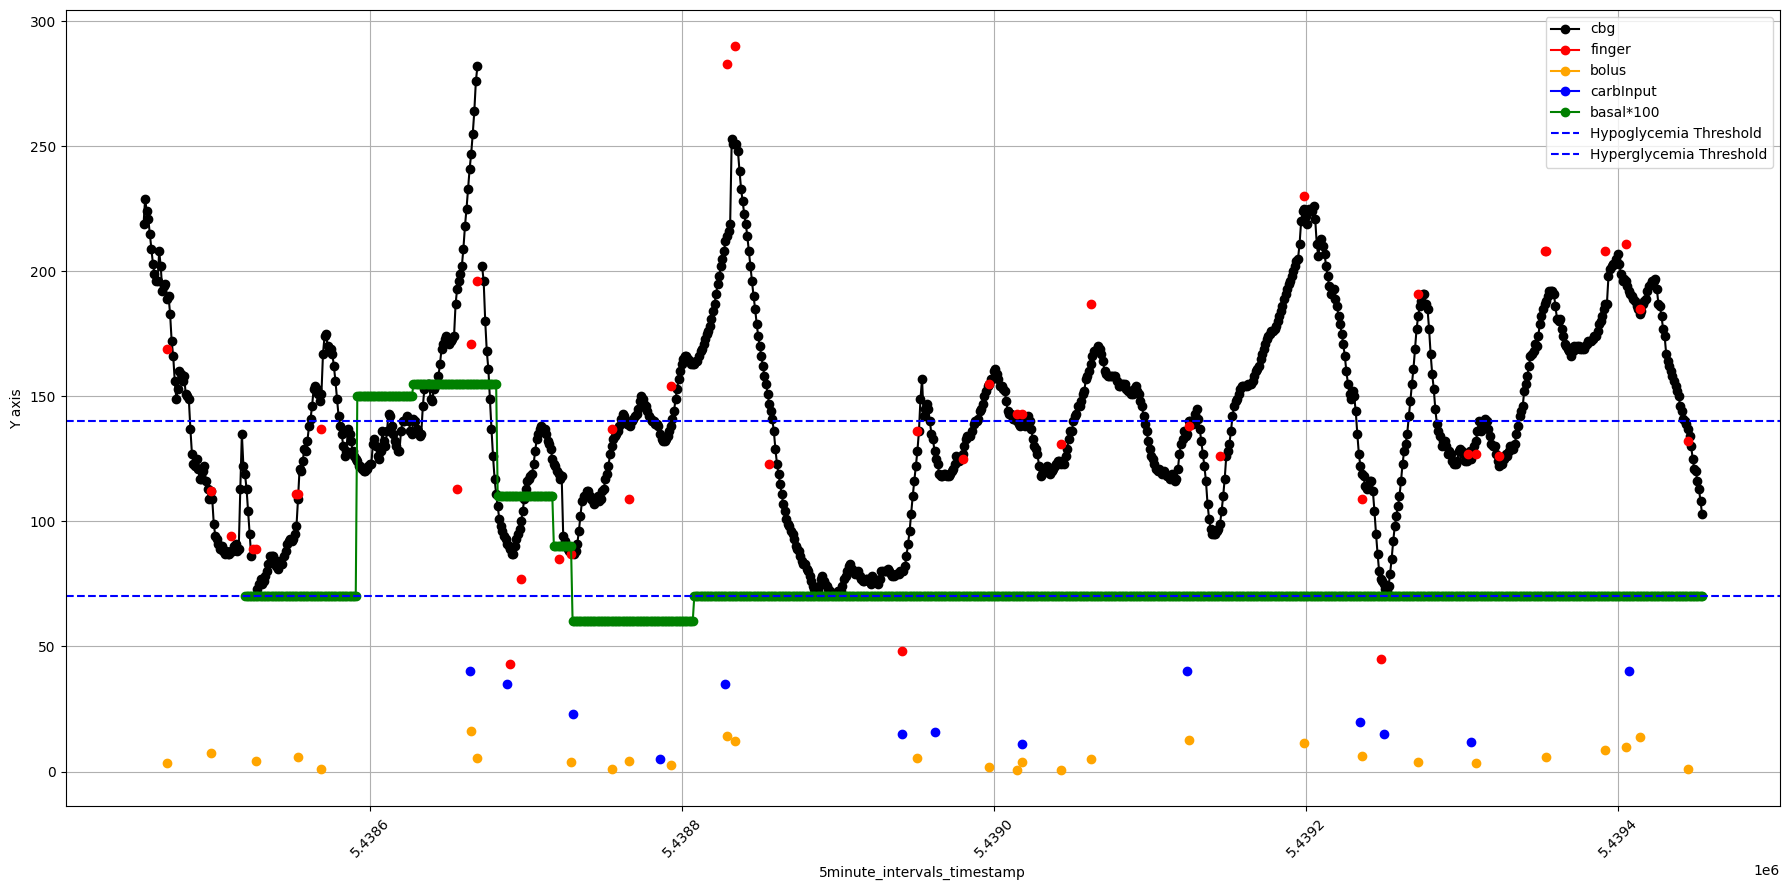

In [5]:
# Load specific patient excel path 

# Load the CSV file into a pandas dataframe
df = pd.read_csv(file_path)

###################################### # code what you want in/out
# Filter rows where 'missing_cbg' is 0 (binary variable) -> this fills holes in cbg line
# filtered_df = df[df['missing_cbg'] == 0].head(1000)

# Or not, I still prefer only taking the first 1000 entries so I can see x,y relationship better
filtered_df = df.head(1000)
#####################################

# Plot lines
plt.figure(figsize=(18, 9))
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['cbg'], marker='o', linestyle='-', color='black', label='cbg')
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['finger'], marker='o', linestyle='-', color='red', label='finger')
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['bolus'], marker='o', linestyle='-', color='orange', label='bolus')
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['carbInput'], marker='o', linestyle='-', color='blue', label='carbInput')
#TODO ADD bolus data to plot 

# I multipled the basal by 100 just so its easier to see in plot
plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['basal']*100, marker='o', linestyle='-', color='green', label='basal*100')

# Variables that we can still plot and see what happens etc. -> hr, gsr, carbInput, bolus
# What I think they mean: hr>heart rate, gsr>Galvanic skin response, carbInput -> carb in grams?, 
# bolus> Insulin delivered to the patient, typically before a meal or when the patient is hyperglycemic.

# Horizontal line representing for hyper- and hypoglycemia, maybe it helps us see 
hypoglycemia_threshold = 70.2  
plt.axhline(y=hypoglycemia_threshold, color='blue', linestyle='--', label='Hypoglycemia Threshold')
hyperglycemia_threshold = 180 
plt.axhline(y=hyperglycemia_threshold, color='blue', linestyle='--', label='Hyperglycemia Threshold')

plt.xlabel('5minute_intervals_timestamp')
plt.ylabel('Y axis')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



### Load Dataset

In [18]:
# Path to the data folder

# Get the current working directory
current_directory = os.getcwd()

# Go one step up from the current directory
parent_directory = os.path.dirname(current_directory)

data_folder = os.path.join(parent_directory, 'dataset')
print(data_folder)

C:\Users\julia\Desktop\Studium_MA5\DataDrivenDiabetesManagement\Project\git\DataDrivenDiabetesSemesterProject\dataset


In [19]:
#data_folder = r'C:\Ohio_Data'

# List of patient excel IDs in the year folders
patient_ids_2018 = [559, 563, 570, 575, 588, 591]
patient_ids_2020 = [540, 544, 552, 567, 584, 596]

train_set_2018 = []
test_set_2018 = []
train_set_2020 = []
test_set_2020 = []

# not super pretty but works:
names_train_2018 = []
names_test_2018 = []
names_train_2020 = []
names_test_2020 = []

# For 2018 data
for patient_id in patient_ids_2018:
    for folder_type in ['training', 'testing']:
        file_name = f"{patient_id}-ws-{folder_type}_processed.csv"
        print(f"Load file: {file_name}")
        if folder_type == 'training':
            names_train_2018.append(file_name)
        else:
            names_test_2018.append(file_name)
        file_path = os.path.join(data_folder, 'Ohio2018_processed', folder_type[:-3], file_name)
        if os.path.exists(file_path): 
            patient_data = pd.read_csv(file_path)
            train_set_2018.append(patient_data) if folder_type == 'training' else test_set_2018.append(patient_data)
        else:
            print(f"File not found: {file_path}")
            raise FileNotFoundError("The target directory does not exist.")

# For 2020 data
for patient_id in patient_ids_2020:
    for folder_type in ['training', 'testing']:
        file_name = f"{patient_id}-ws-{folder_type}_processed.csv"
        print(f"Load file: {file_name}")
        if folder_type == 'training':
            names_train_2020.append(file_name)
        else:
            names_test_2020.append(file_name)
        file_path = os.path.join(data_folder, 'Ohio2020_processed', folder_type[:-3], file_name)
        if os.path.exists(file_path): 
            patient_data = pd.read_csv(file_path)
            train_set_2020.append(patient_data) if folder_type == 'training' else test_set_2020.append(patient_data)
        else:
            print(f"File not found: {file_path}")
            raise FileNotFoundError("The target directory does not exist.")

Load file: 559-ws-training_processed.csv
Load file: 559-ws-testing_processed.csv
Load file: 563-ws-training_processed.csv
Load file: 563-ws-testing_processed.csv
Load file: 570-ws-training_processed.csv
Load file: 570-ws-testing_processed.csv
Load file: 575-ws-training_processed.csv
Load file: 575-ws-testing_processed.csv
Load file: 588-ws-training_processed.csv
Load file: 588-ws-testing_processed.csv
Load file: 591-ws-training_processed.csv
Load file: 591-ws-testing_processed.csv
Load file: 540-ws-training_processed.csv
Load file: 540-ws-testing_processed.csv
Load file: 544-ws-training_processed.csv
Load file: 544-ws-testing_processed.csv
Load file: 552-ws-training_processed.csv
Load file: 552-ws-testing_processed.csv
Load file: 567-ws-training_processed.csv
Load file: 567-ws-testing_processed.csv
Load file: 584-ws-training_processed.csv
Load file: 584-ws-testing_processed.csv
Load file: 596-ws-training_processed.csv
Load file: 596-ws-testing_processed.csv


## Correlation among independant variables of full dataset of required variables

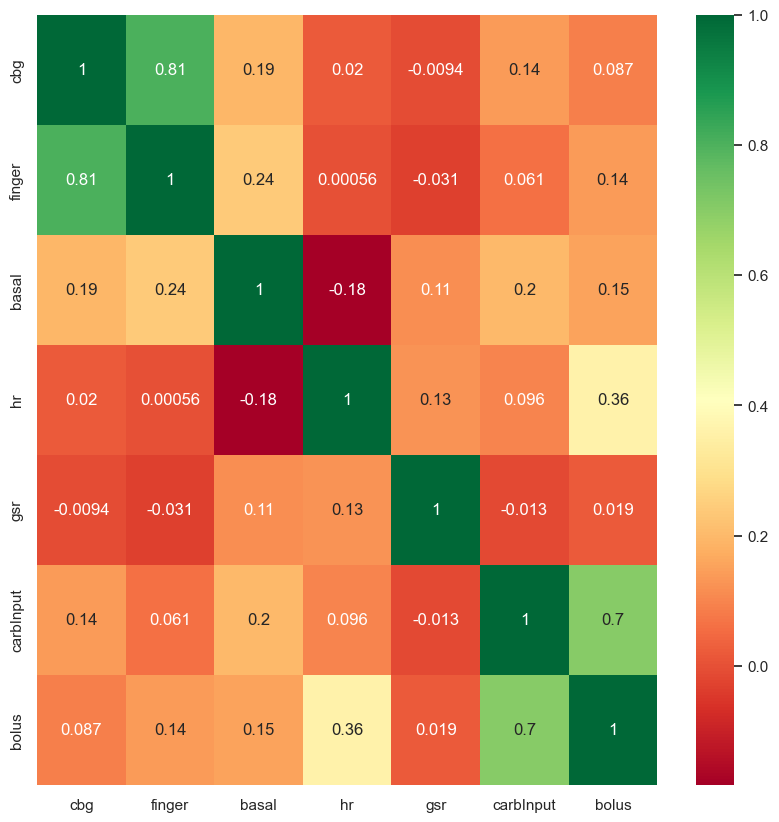

In [20]:
import seaborn as sns
# To plot correlation of all patients together we need to concatenate the datasets of each patient together
all_train_2018 = pd.concat(train_set_2018, ignore_index=True)
all_test_2018 = pd.concat(test_set_2018, ignore_index=True)

all_train_2020 = pd.concat(train_set_2020, ignore_index=True)
all_test_2020 = pd.concat(test_set_2020, ignore_index=True)

# Concatenate all training and testing sets from both years
data = pd.concat([all_train_2018, all_test_2018, all_train_2020, all_test_2020], ignore_index=True)
data_reduced = data.drop(['5minute_intervals_timestamp', 'missing_cbg'], axis=1)
# Reset the index of the dataframe
data_reduced.reset_index(drop=True, inplace=True)

sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
    
#get correlations of each features in dataset
corrmat = pd.DataFrame(data_reduced).corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
corrMatrix=sns.heatmap(pd.DataFrame(data_reduced).corr(),annot=True,cmap="RdYlGn")

### Show all Patients (CGM and SMBG)

Data: train_set_2018
Patient:  559-ws-training_processed.csv


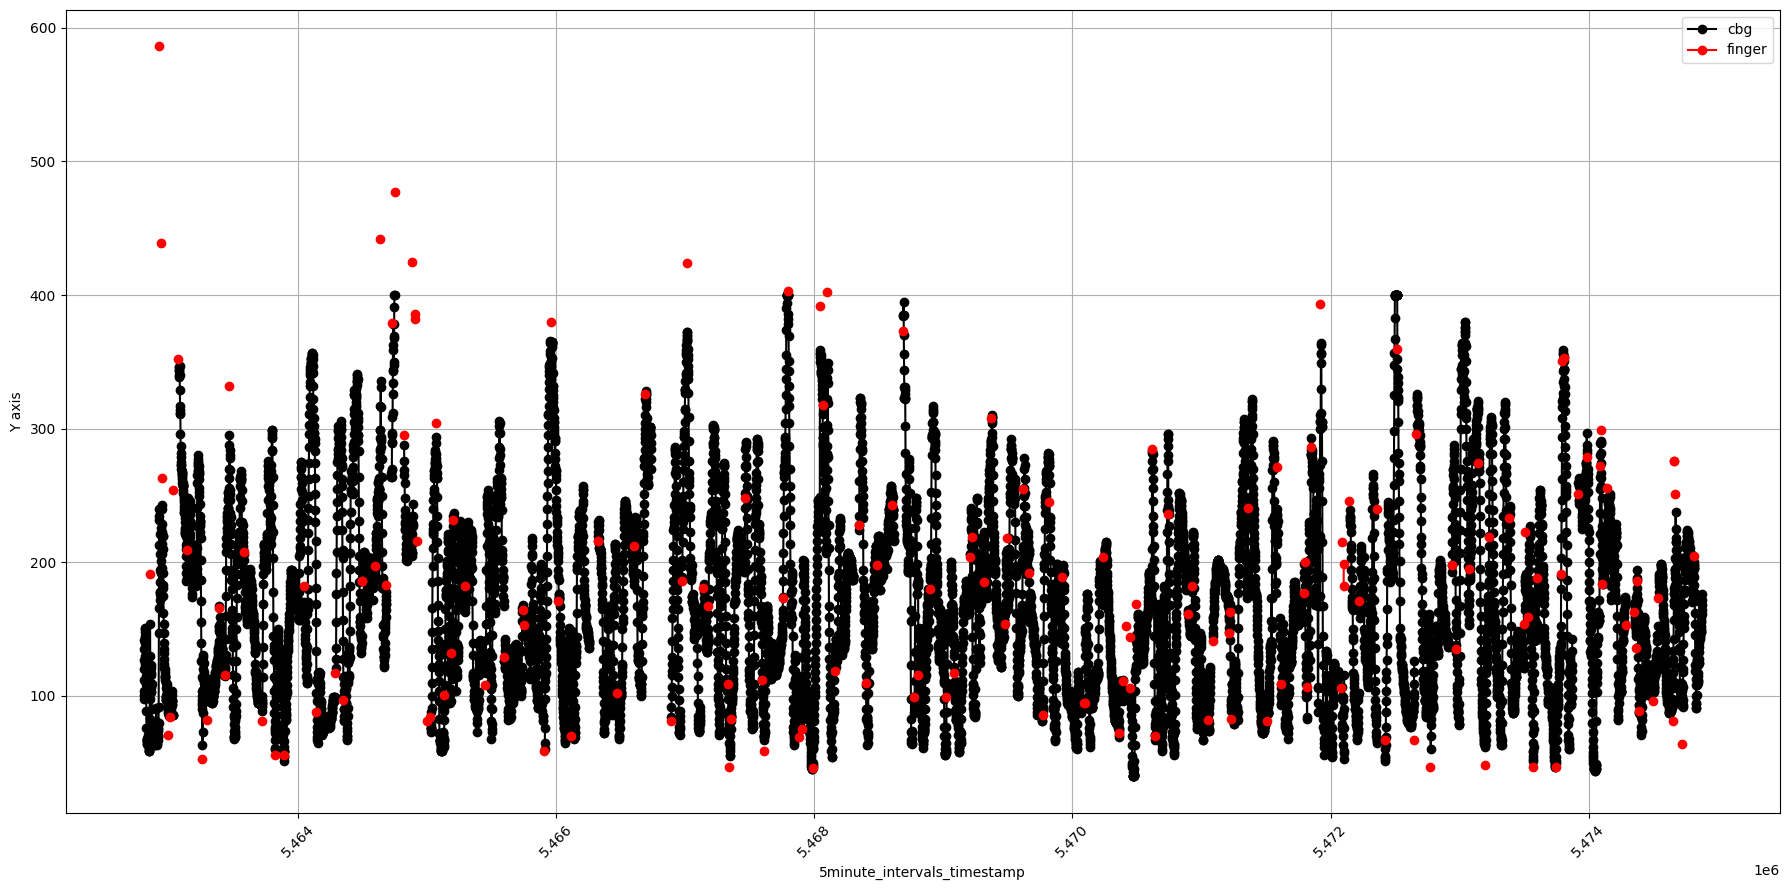

Patient:  563-ws-training_processed.csv


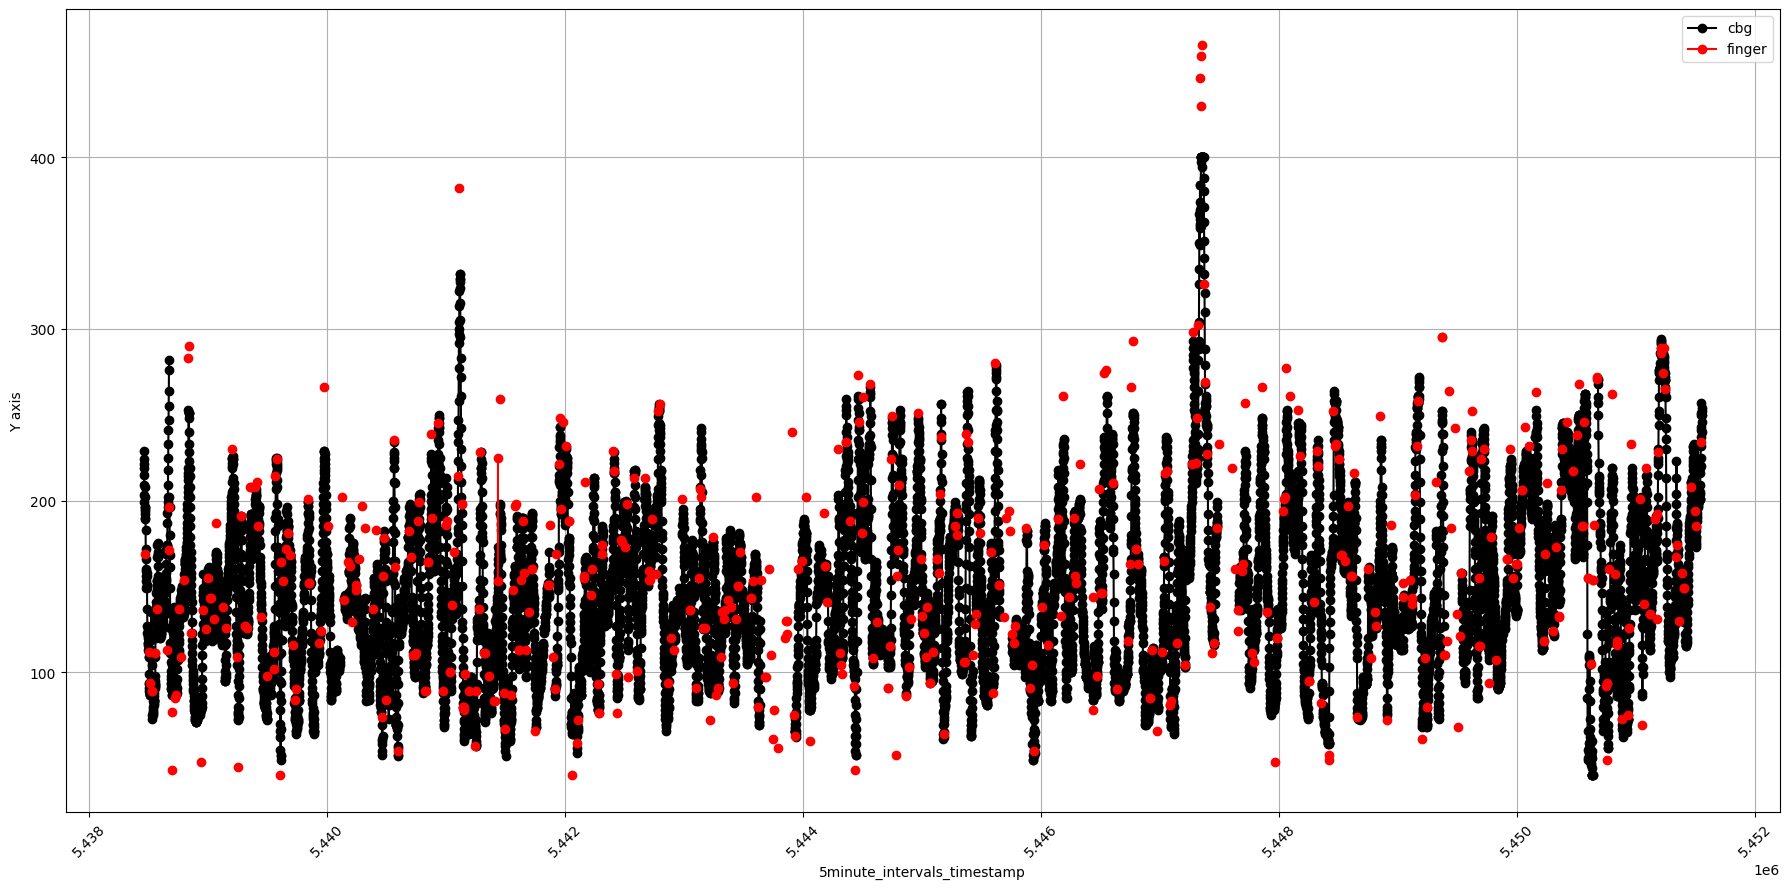

Patient:  570-ws-training_processed.csv


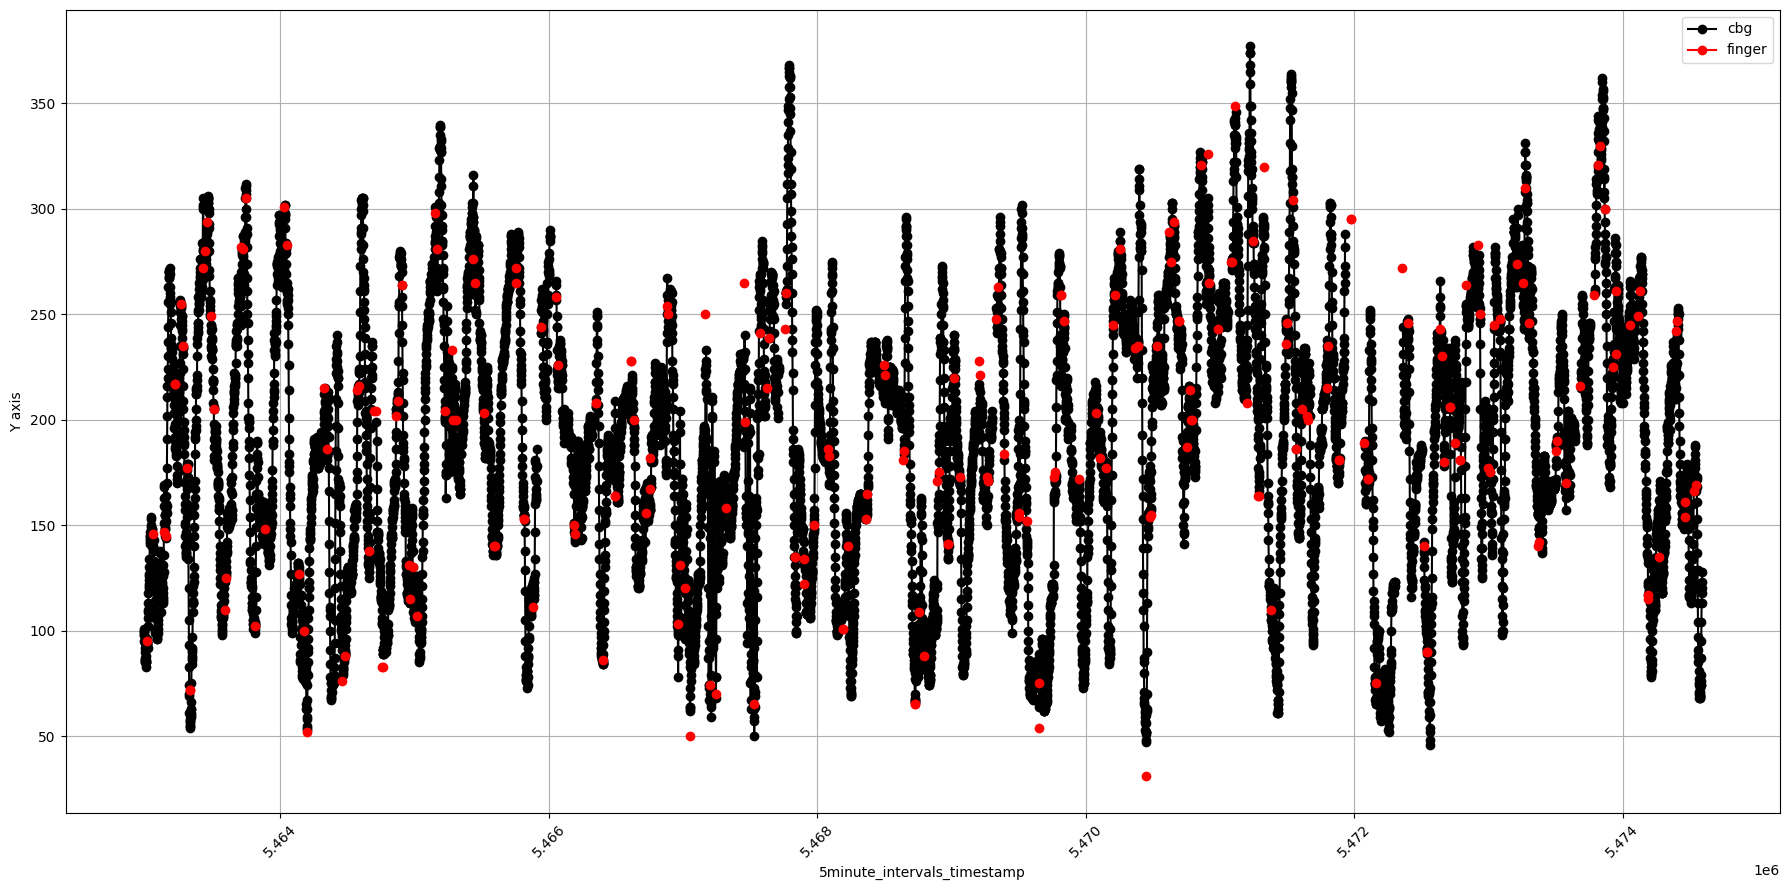

Patient:  575-ws-training_processed.csv


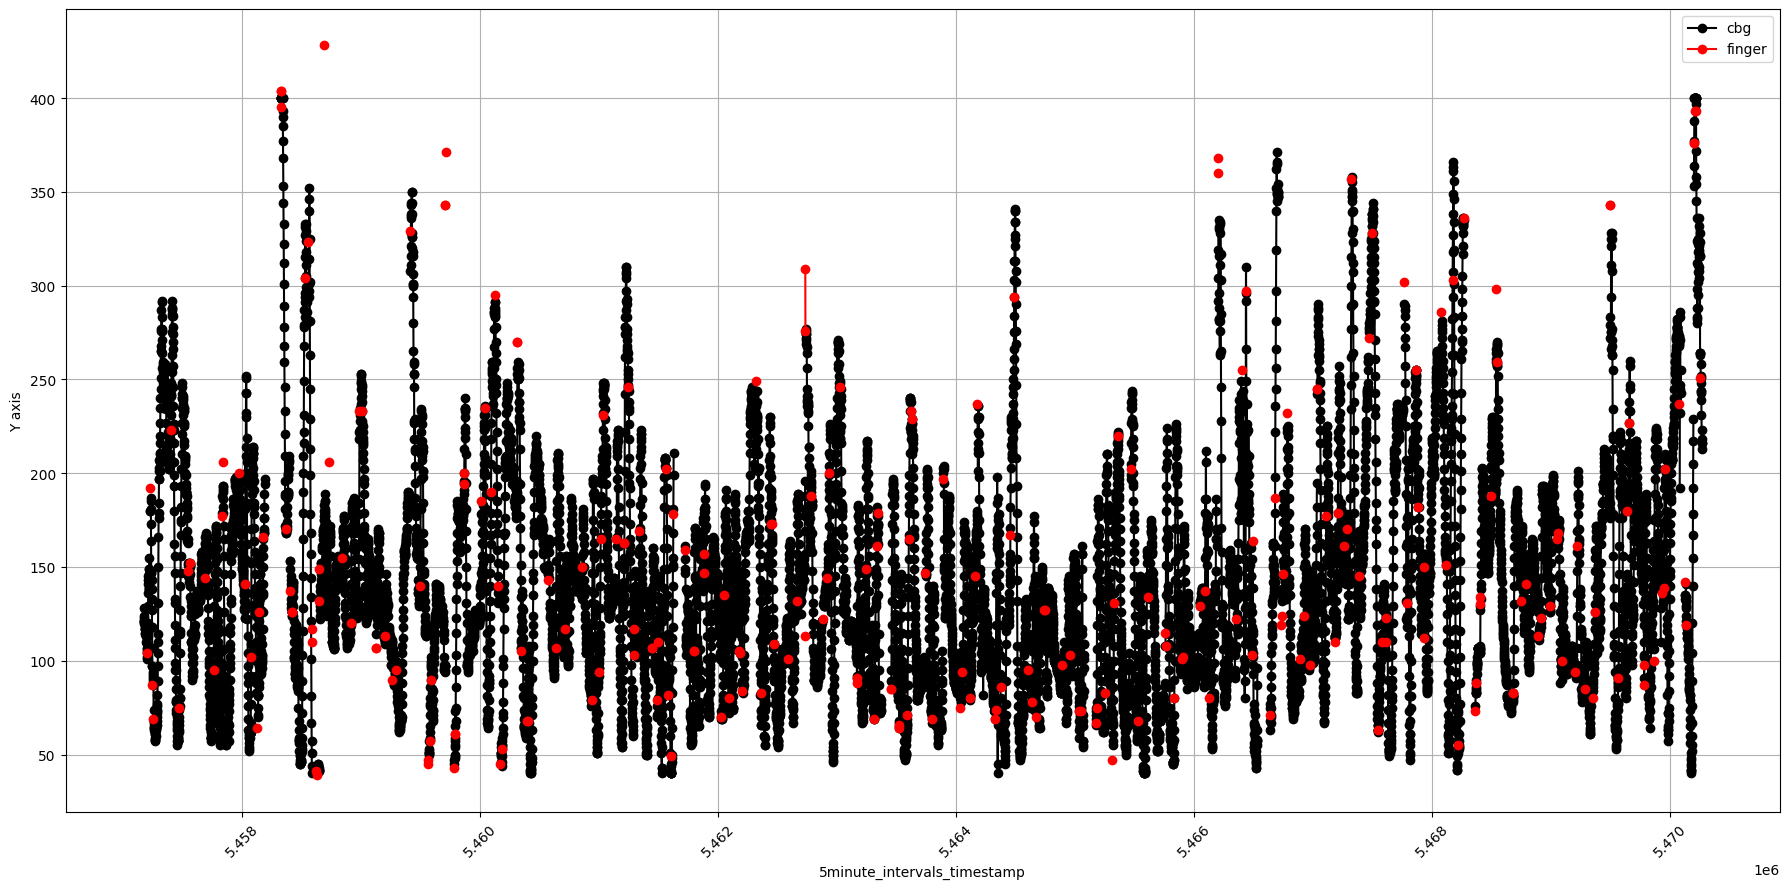

Patient:  588-ws-training_processed.csv


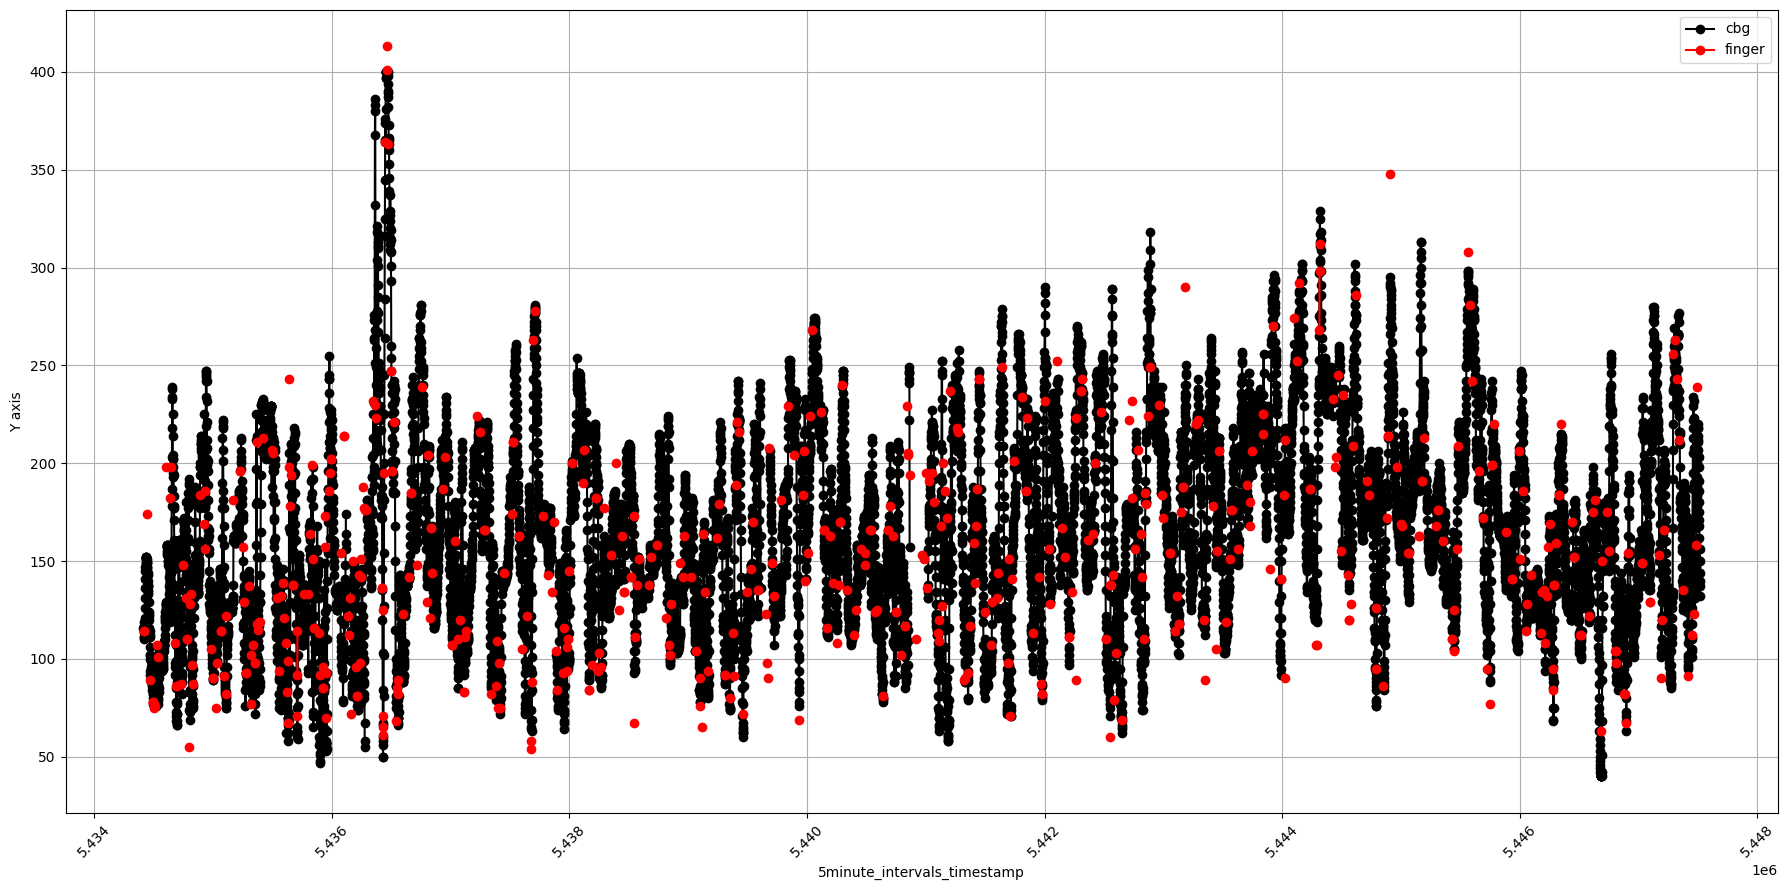

Patient:  591-ws-training_processed.csv


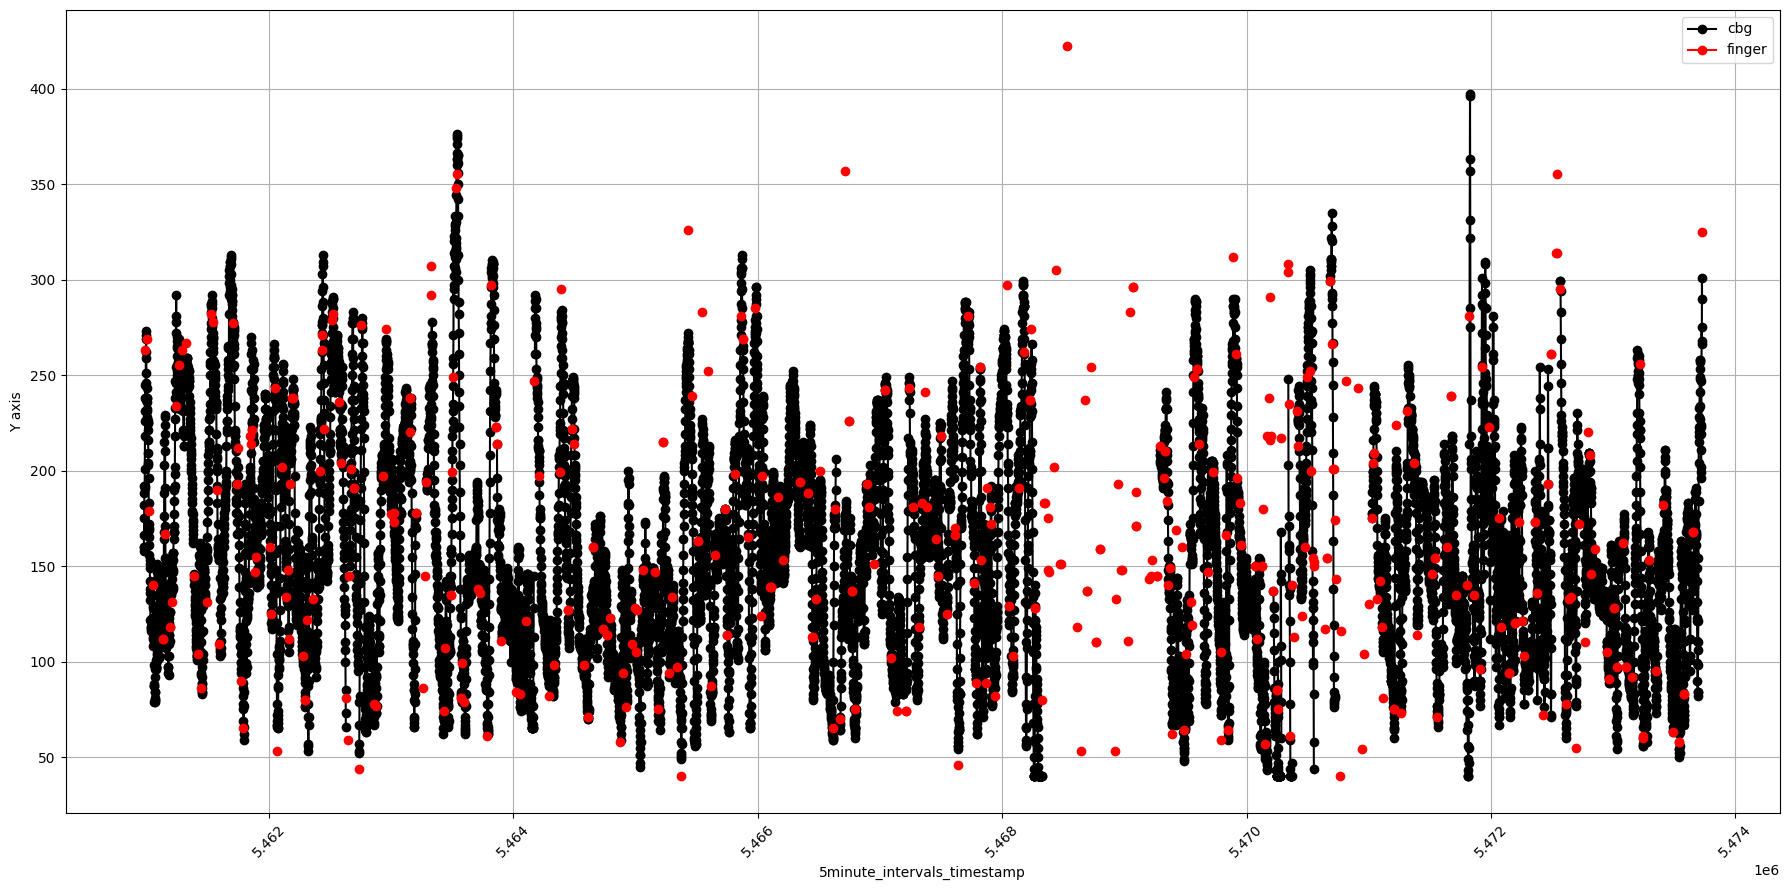

Data: test_set_2018
Patient:  559-ws-testing_processed.csv


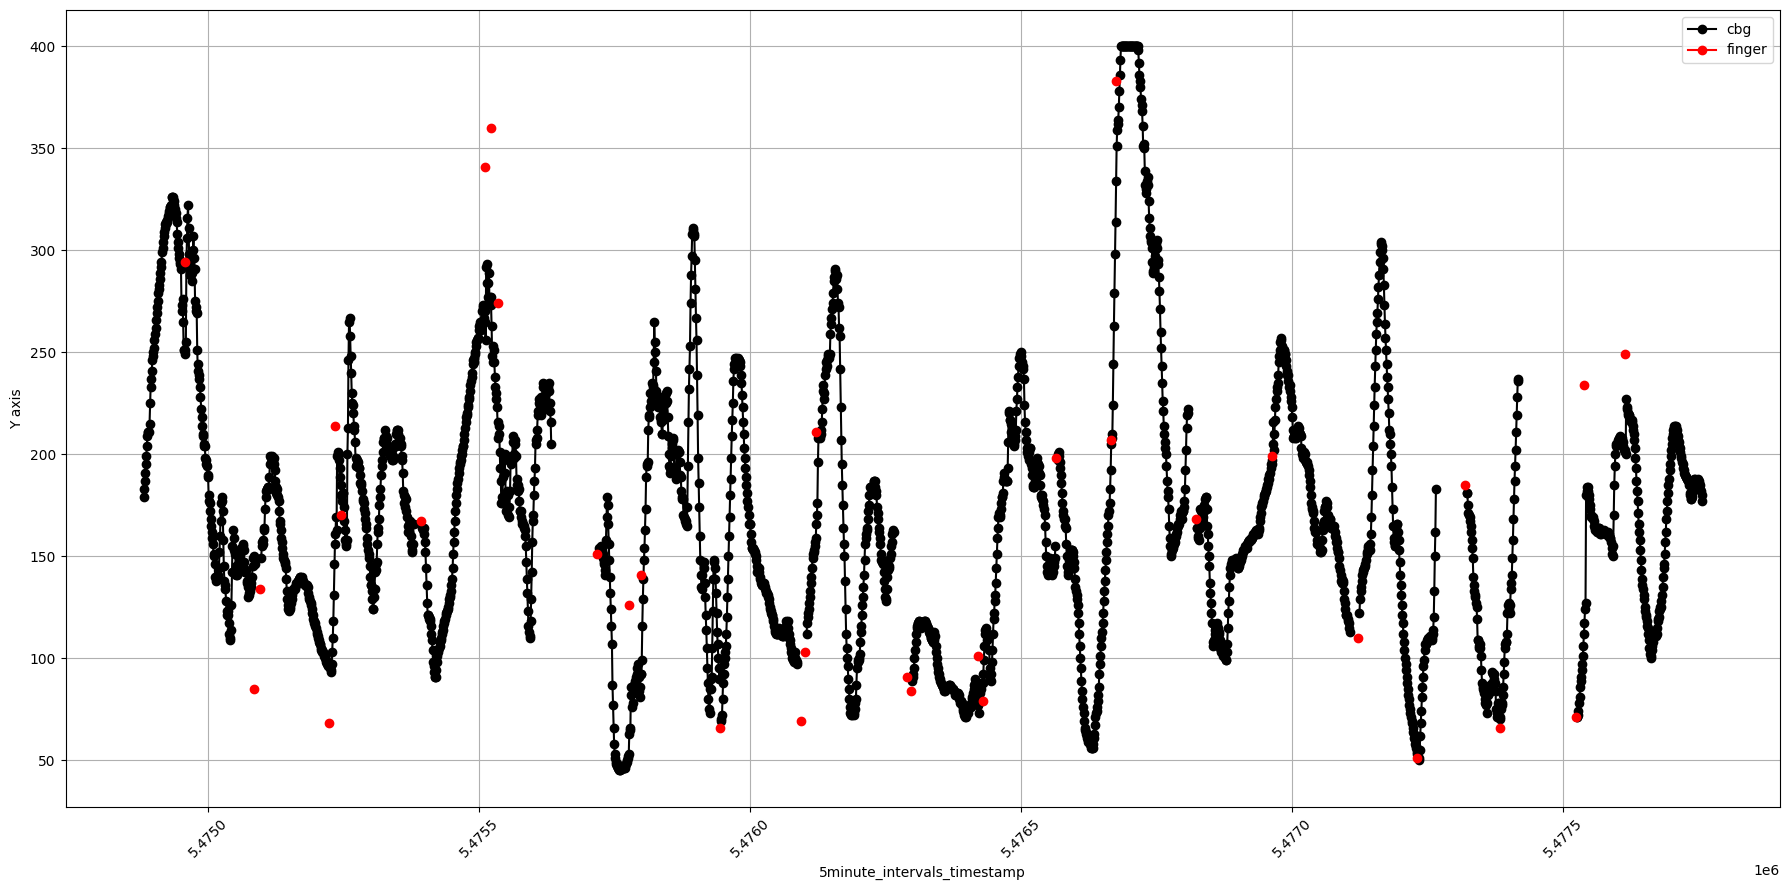

Patient:  563-ws-testing_processed.csv


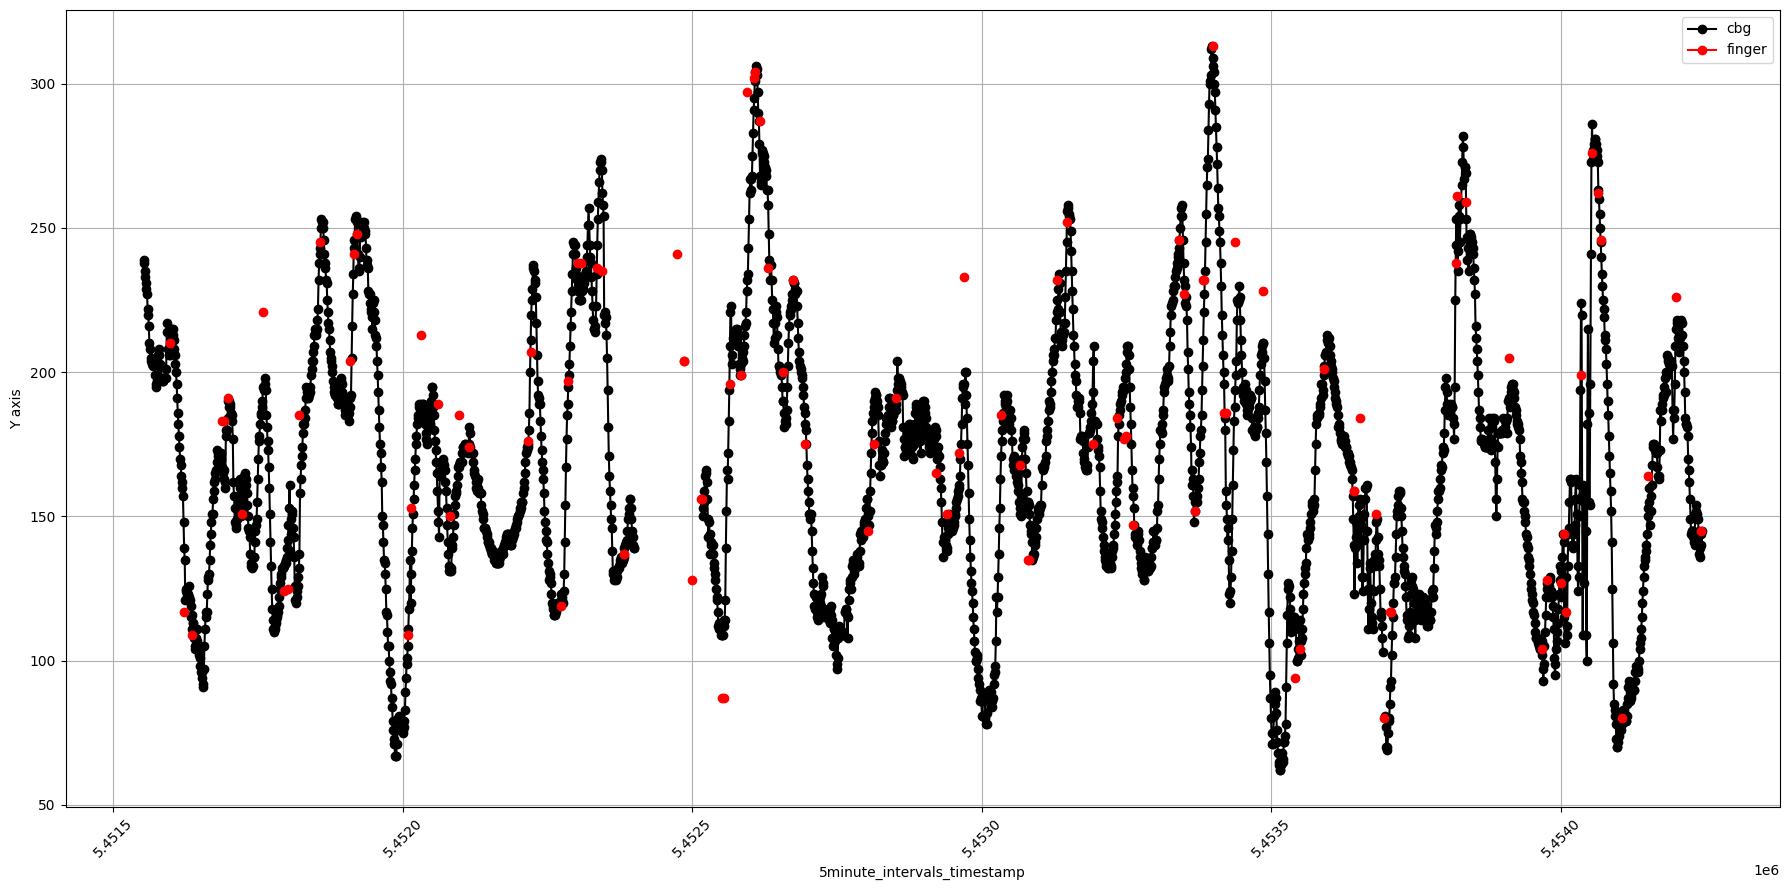

Patient:  570-ws-testing_processed.csv


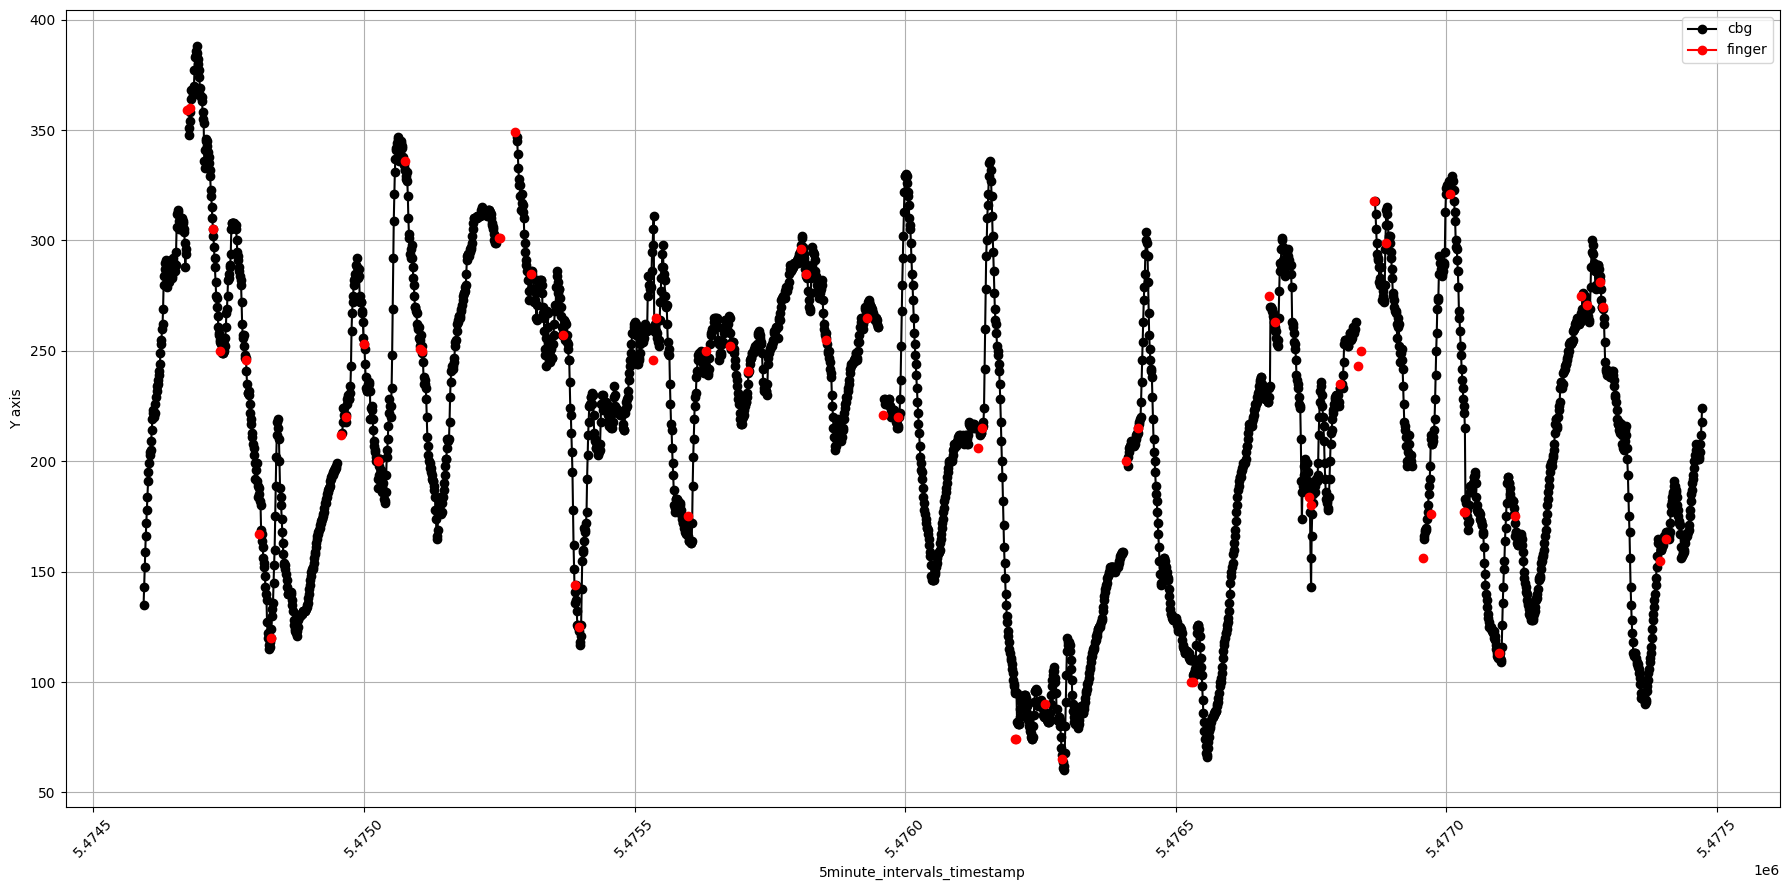

Patient:  575-ws-testing_processed.csv


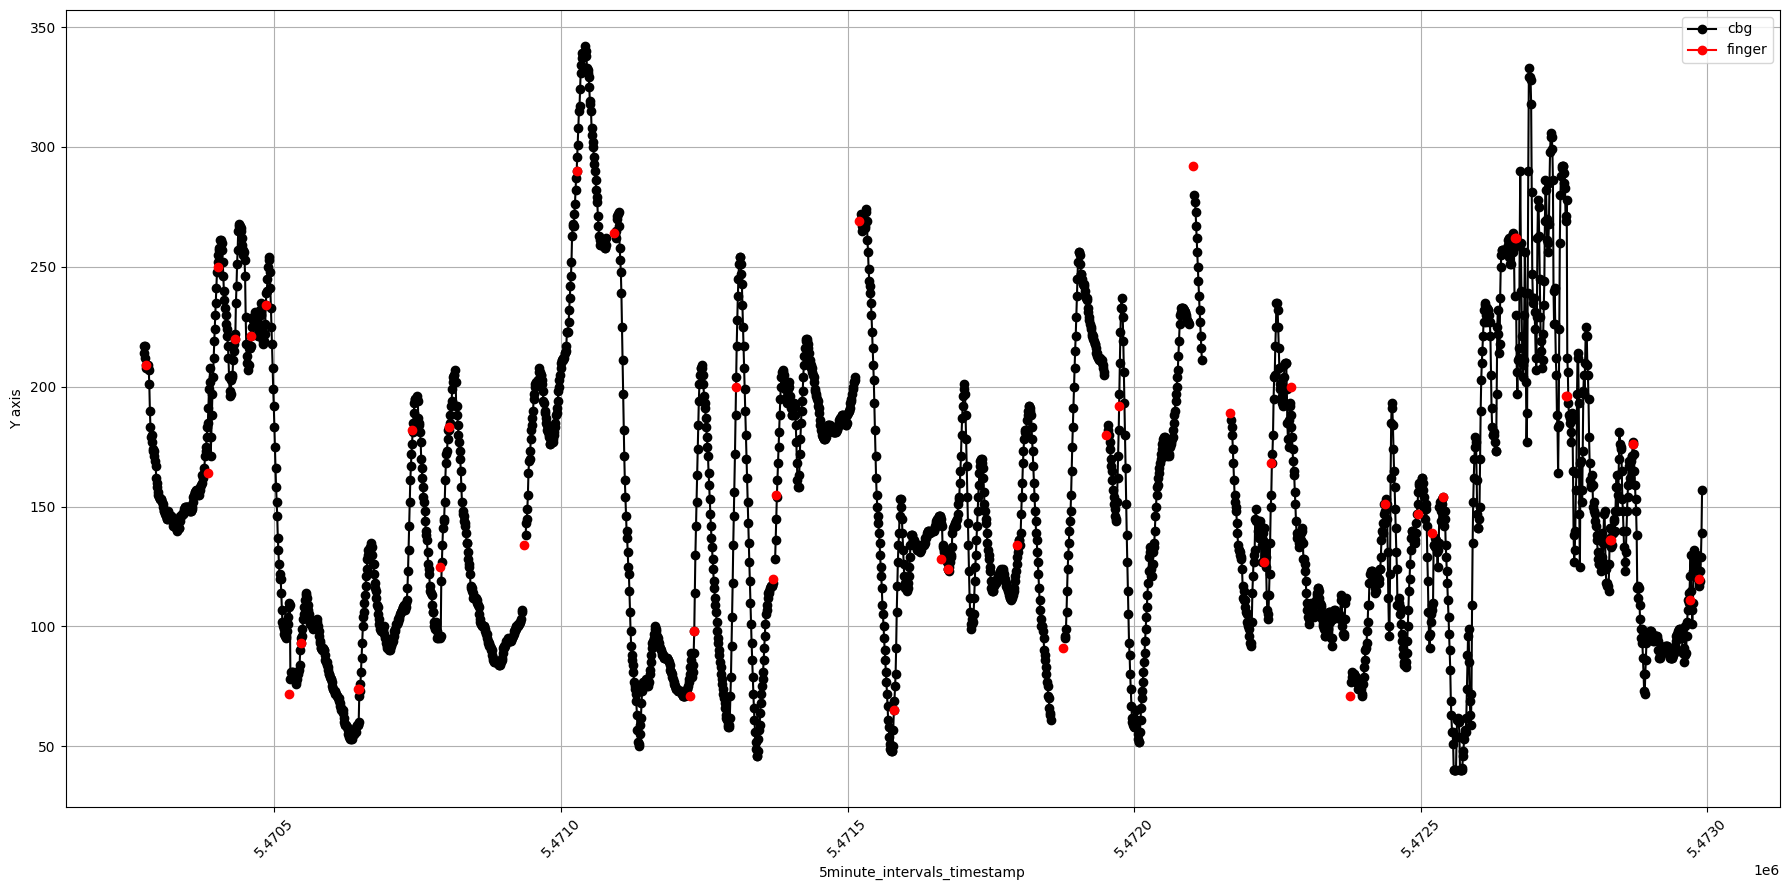

Patient:  588-ws-testing_processed.csv


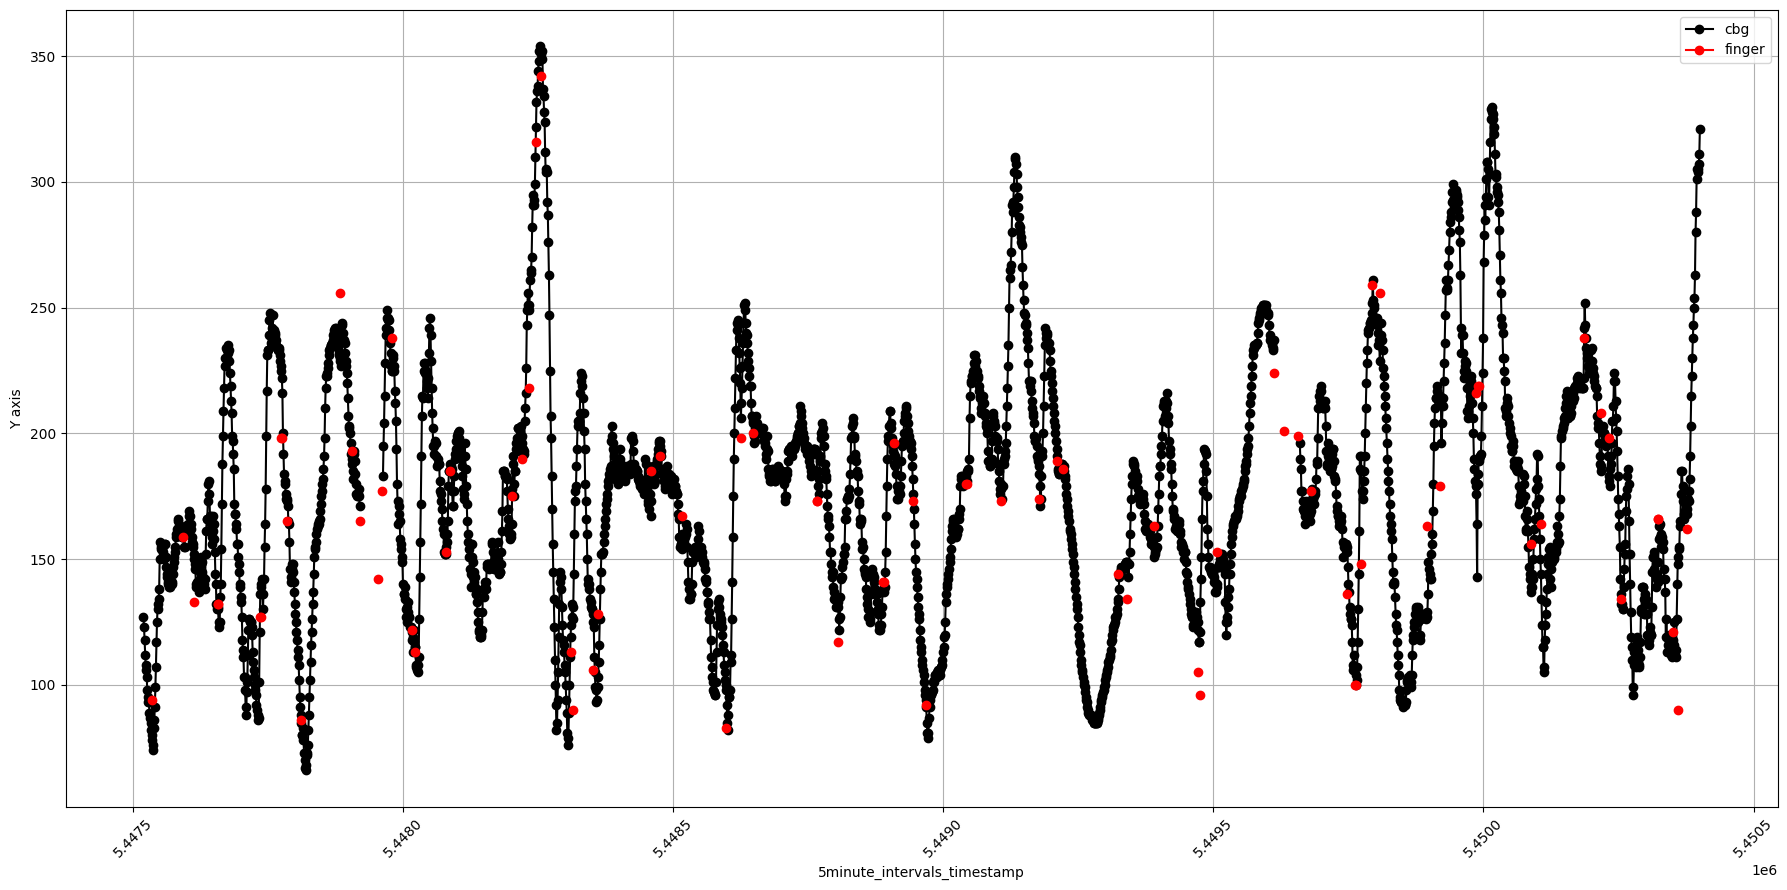

Patient:  591-ws-testing_processed.csv


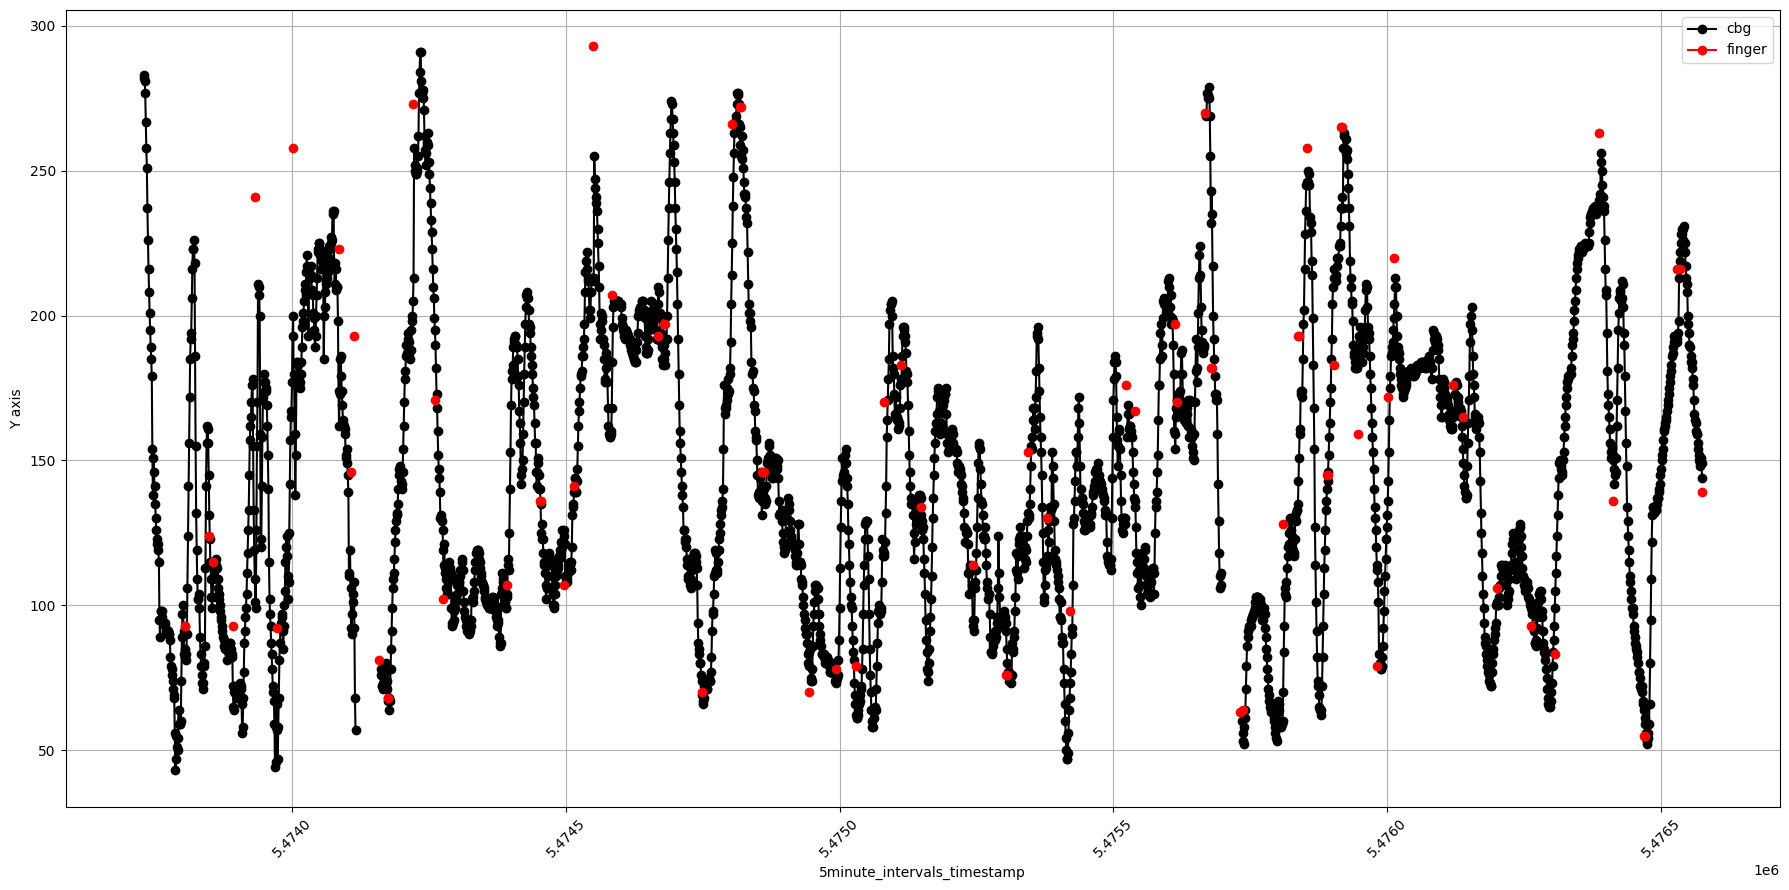

Data: train_set_2020
Patient:  540-ws-training_processed.csv


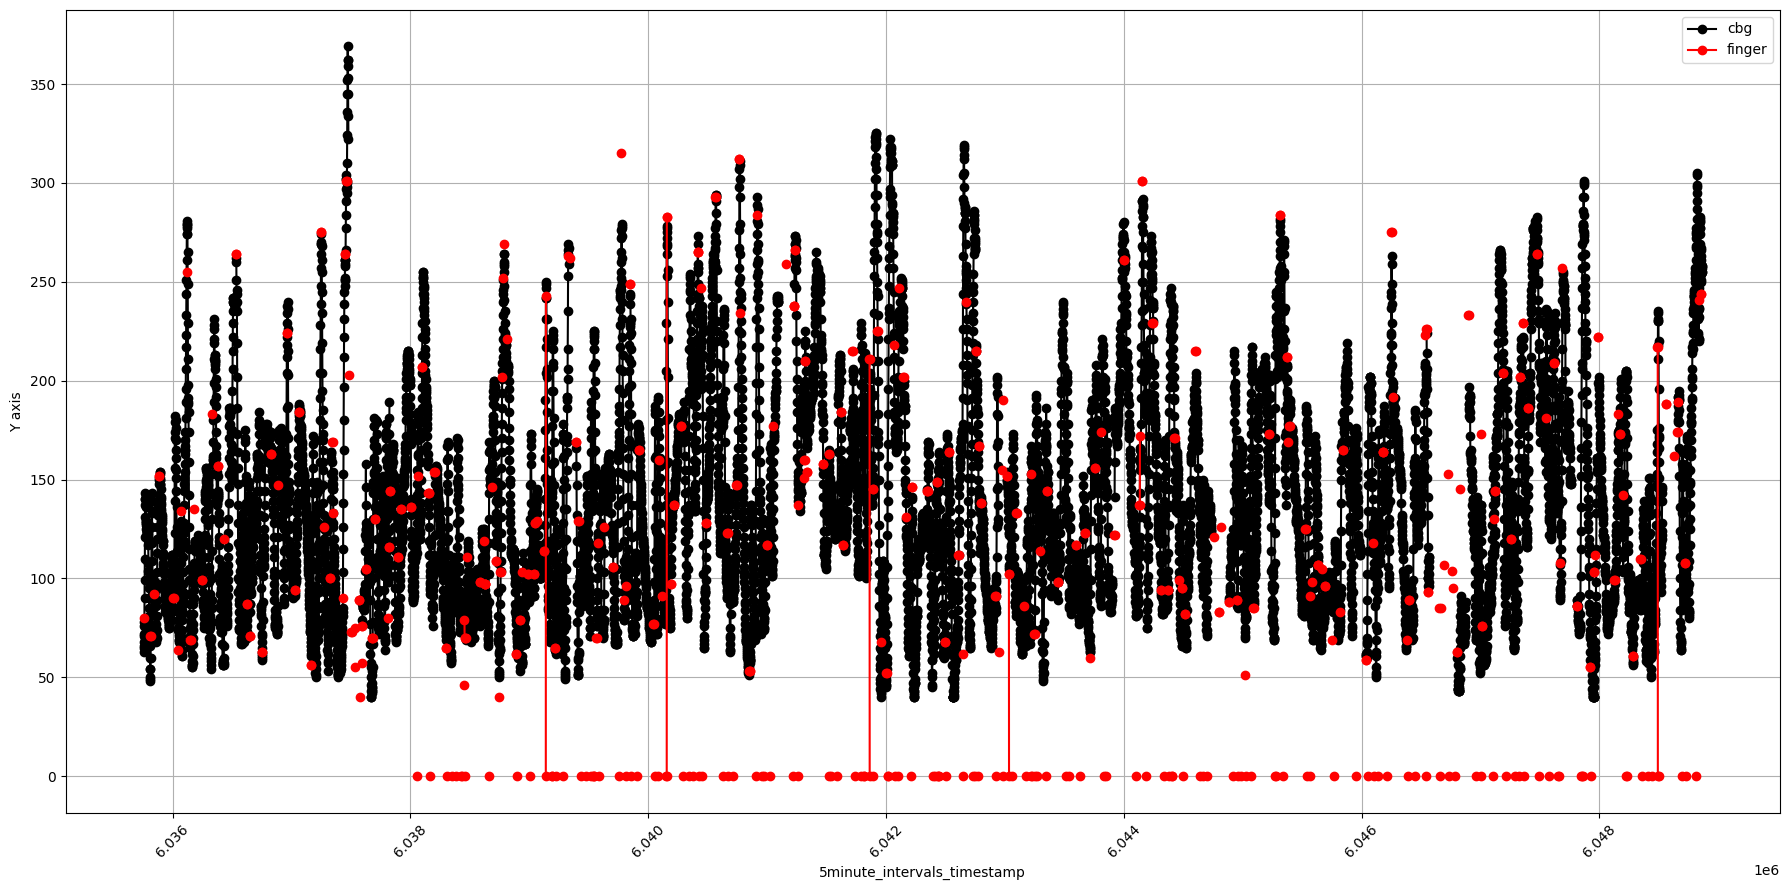

Patient:  544-ws-training_processed.csv


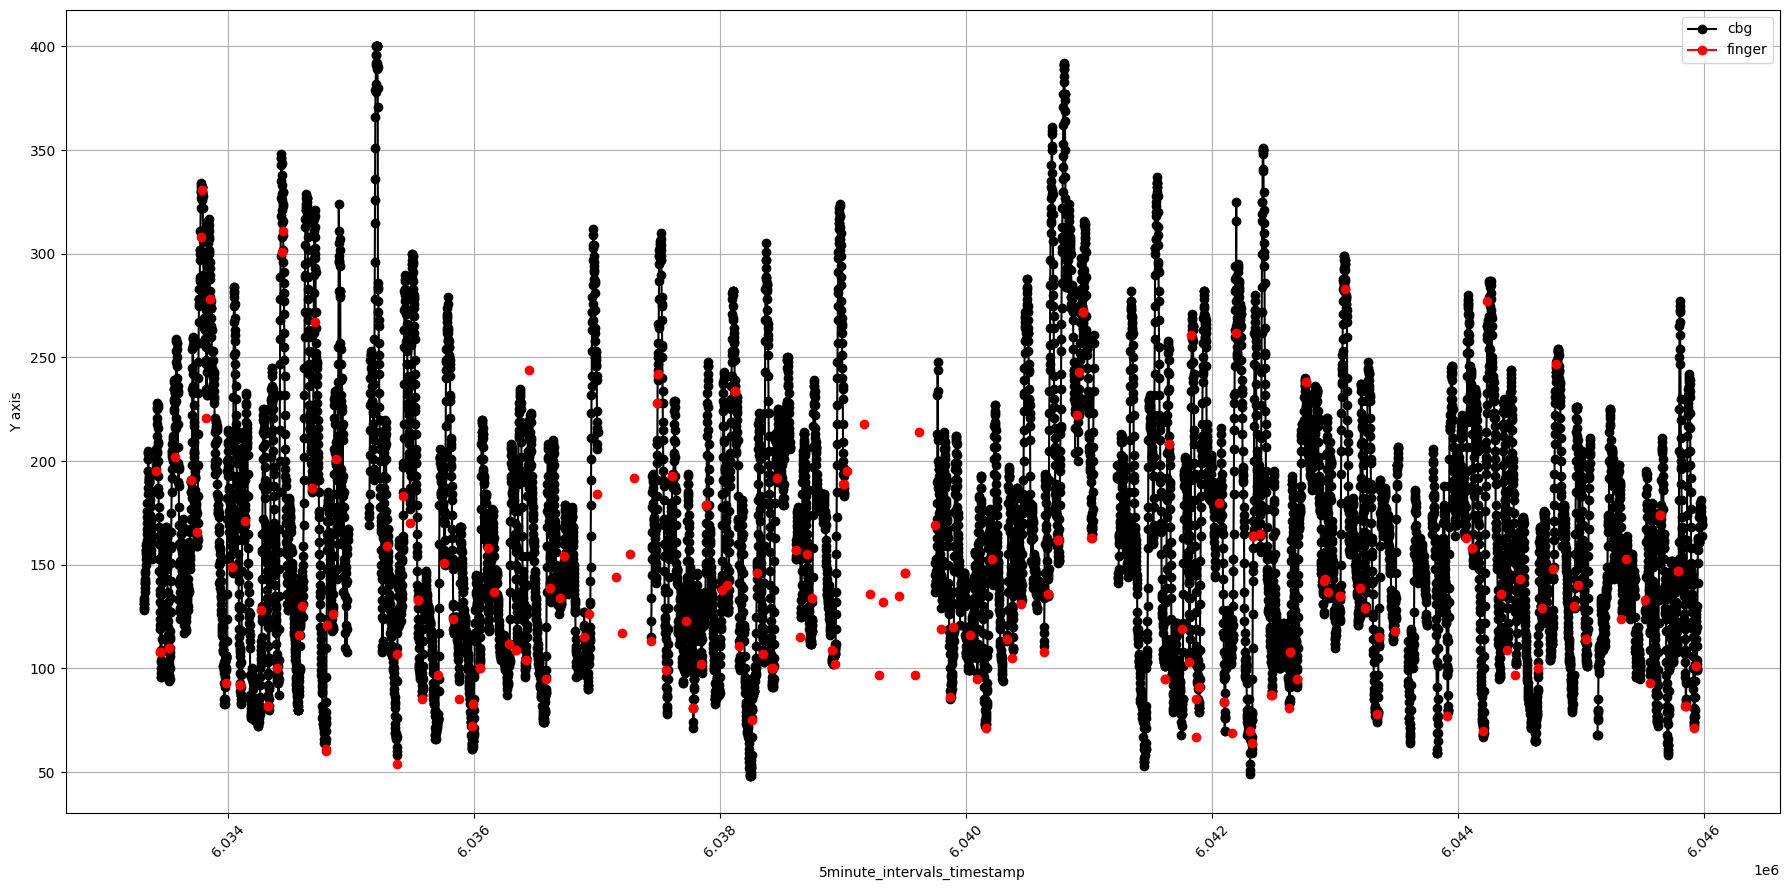

Patient:  552-ws-training_processed.csv


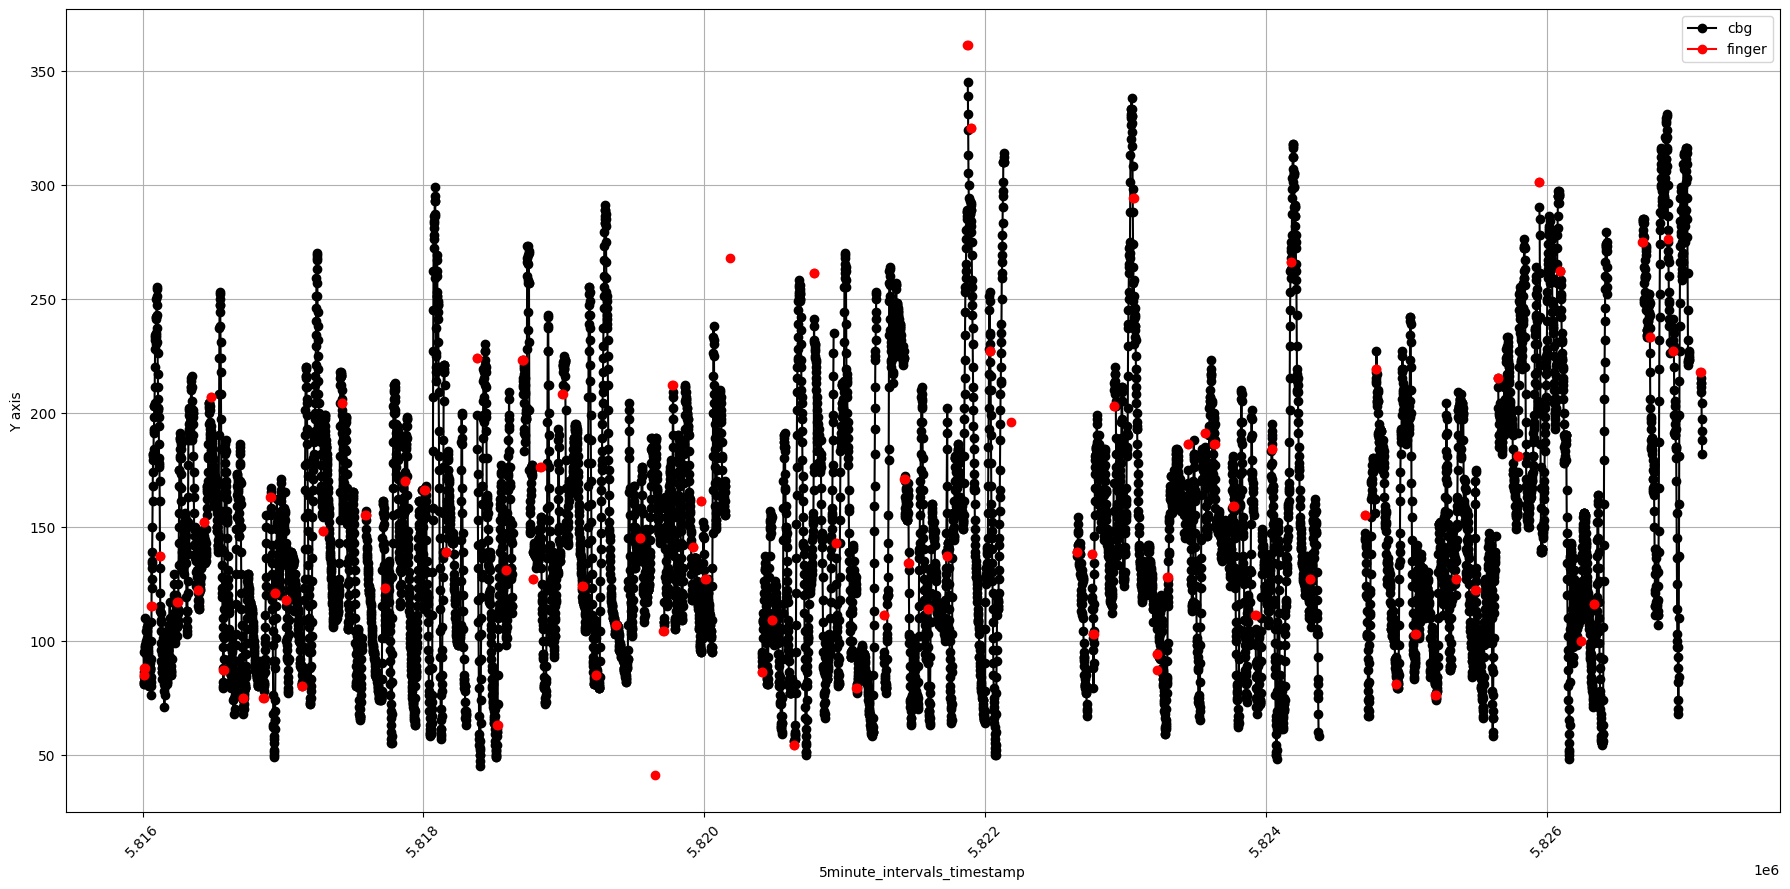

Patient:  567-ws-training_processed.csv


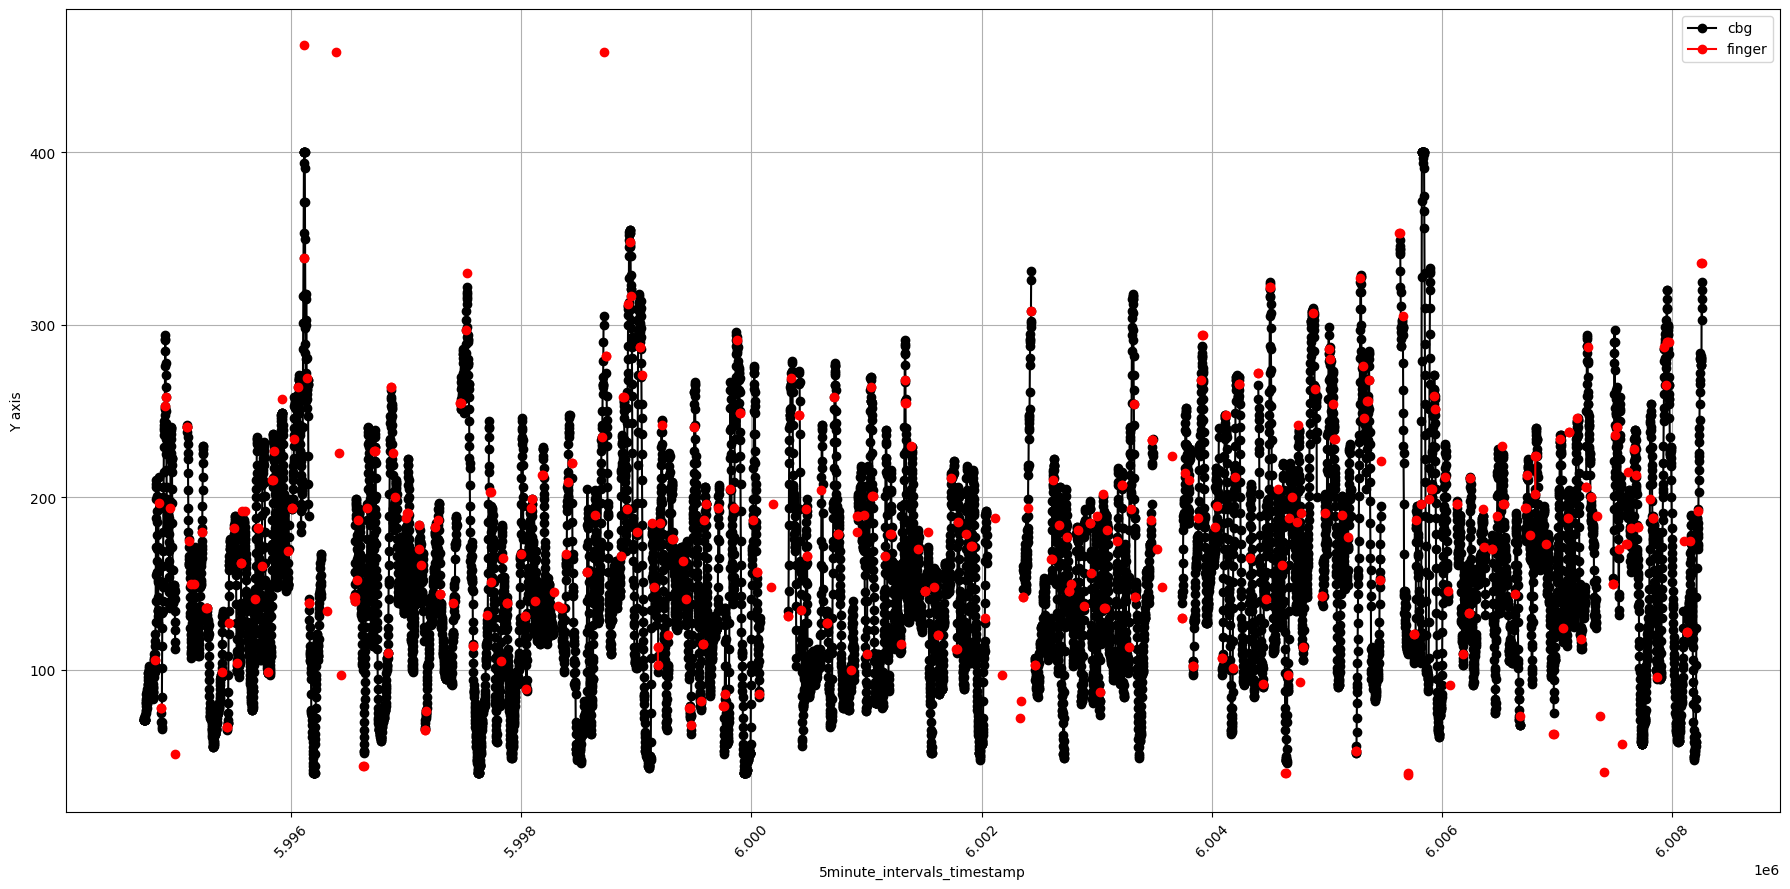

Patient:  584-ws-training_processed.csv


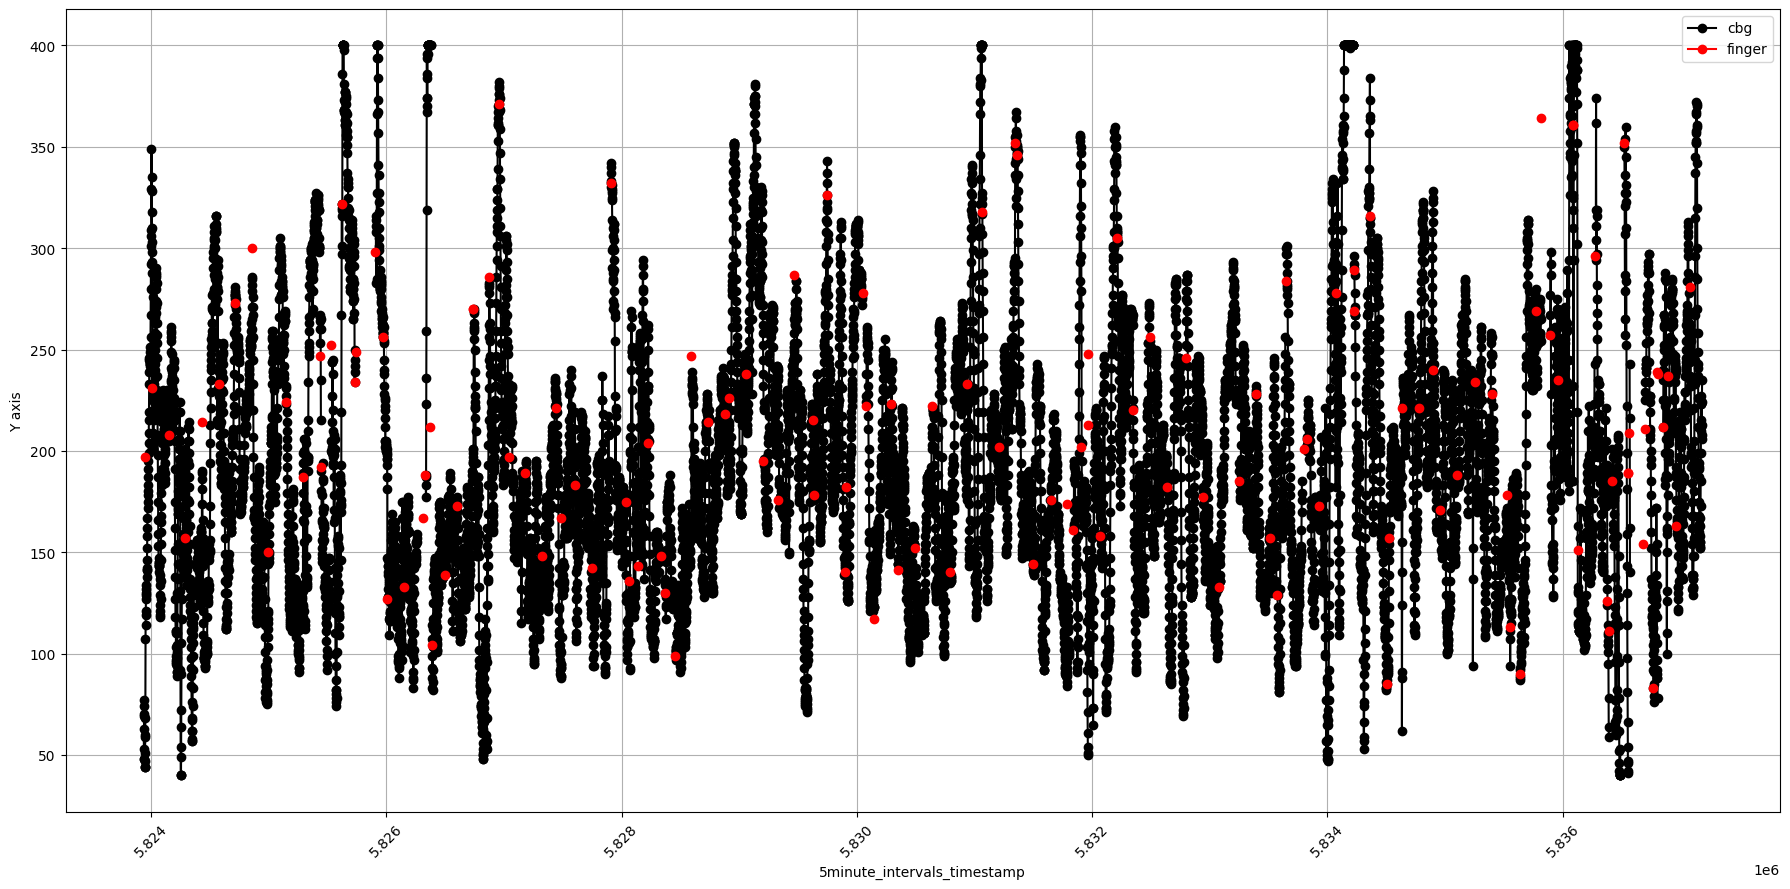

Patient:  596-ws-training_processed.csv


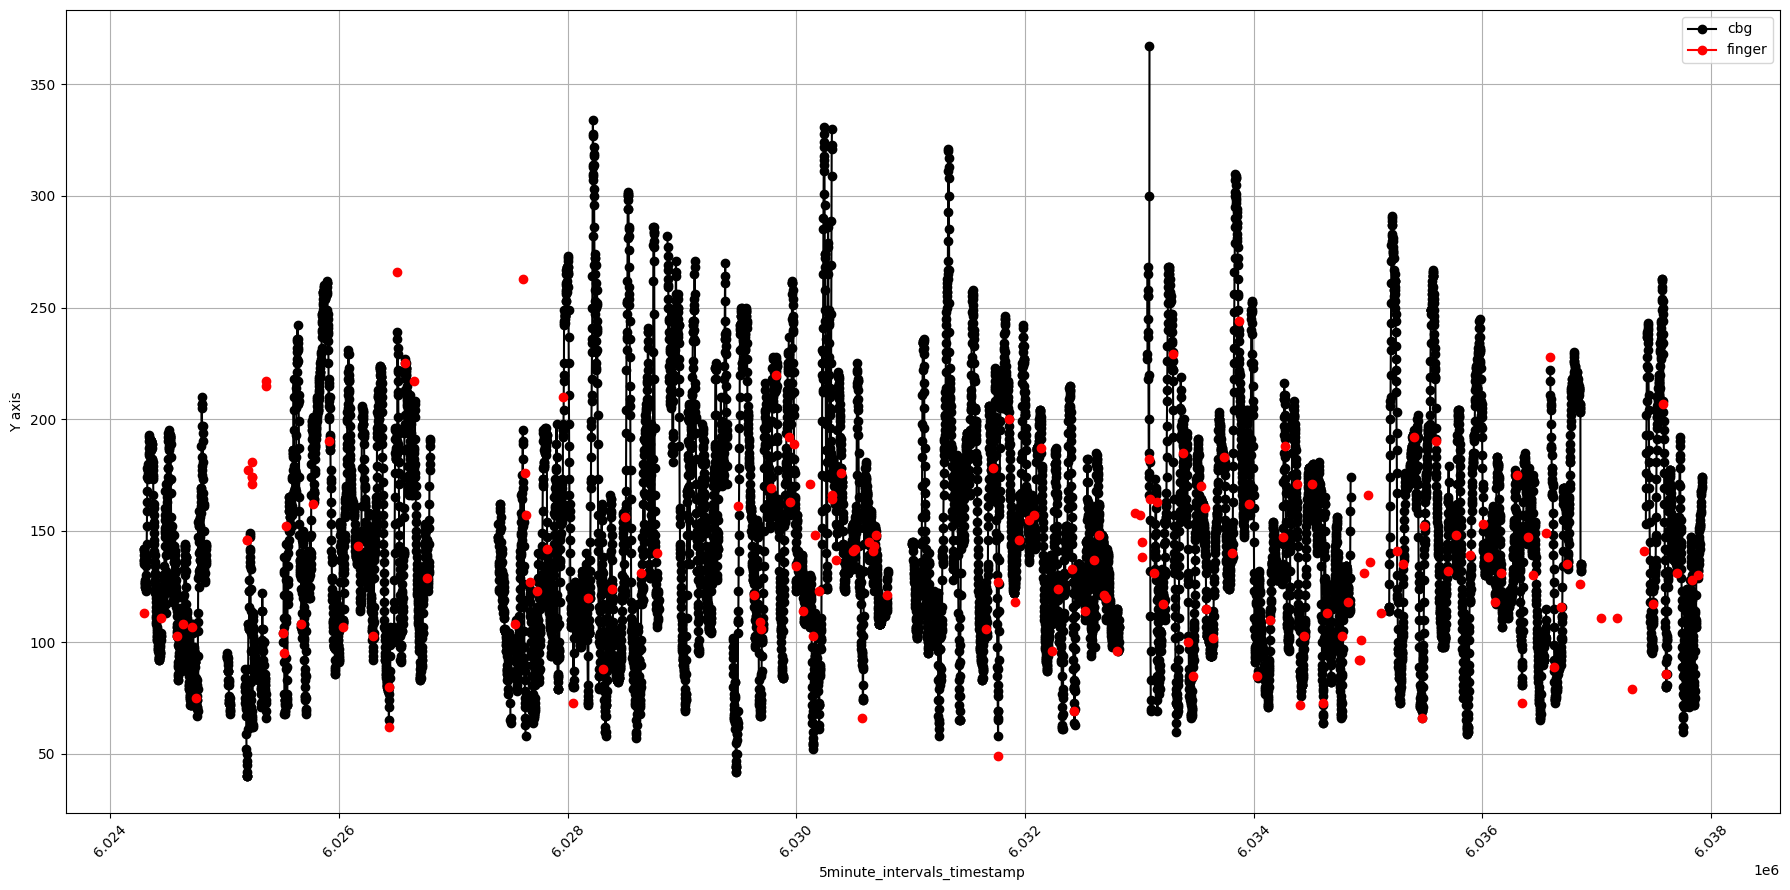

Data: test_set_2020
Patient:  540-ws-testing_processed.csv


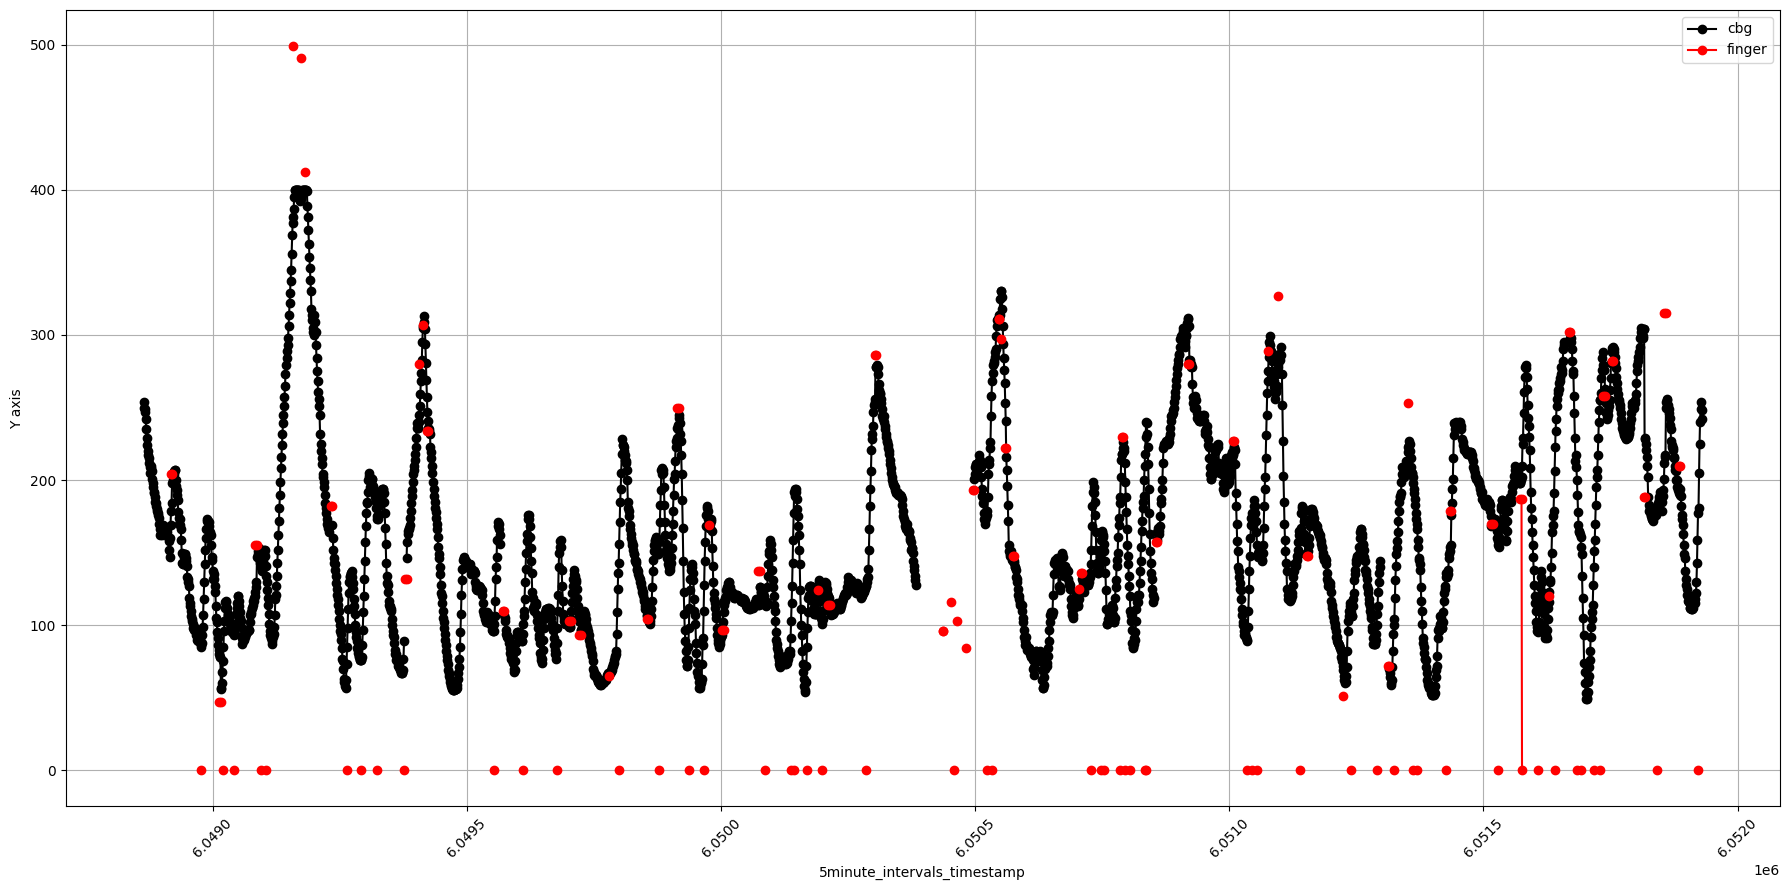

Patient:  544-ws-testing_processed.csv


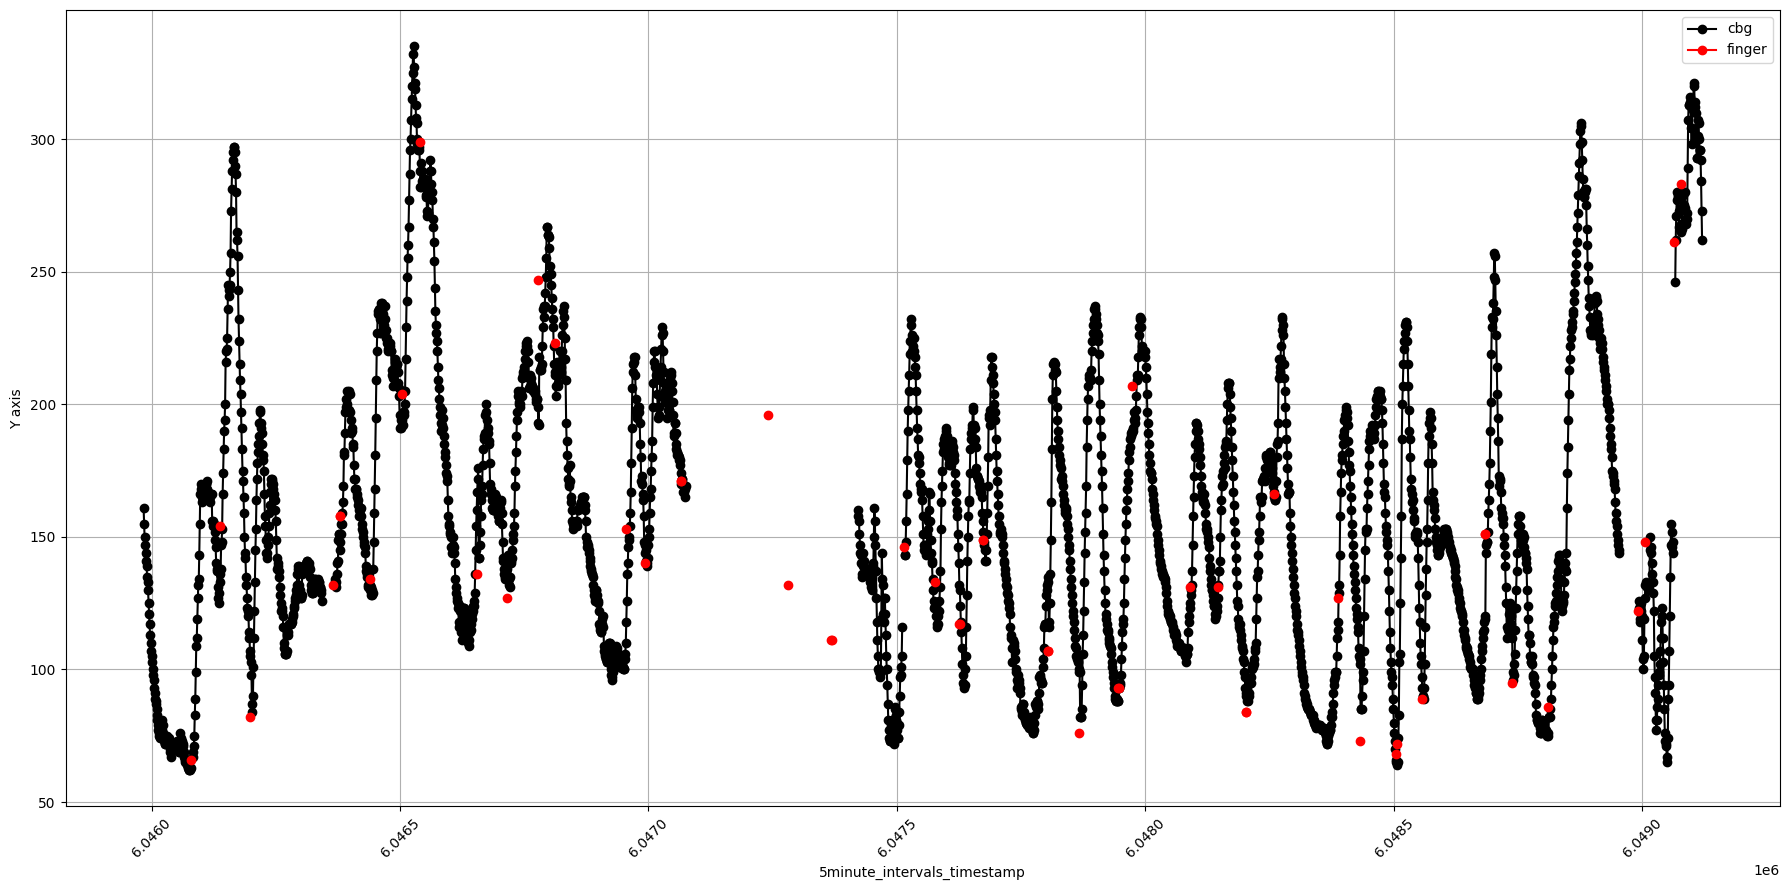

Patient:  552-ws-testing_processed.csv


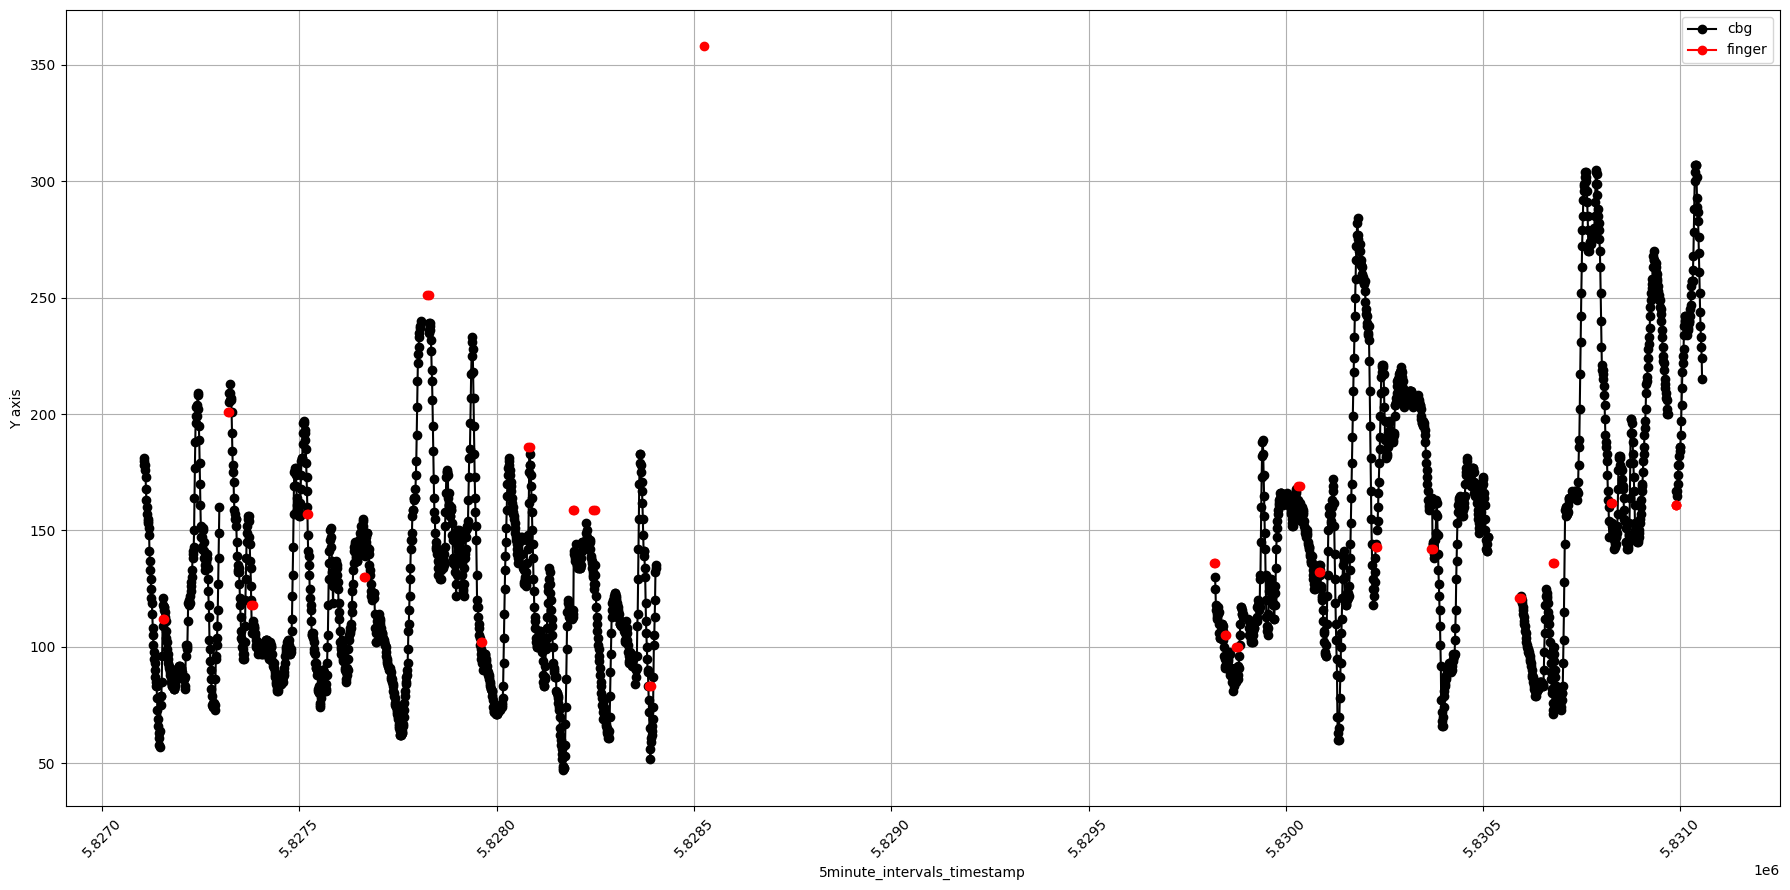

Patient:  567-ws-testing_processed.csv


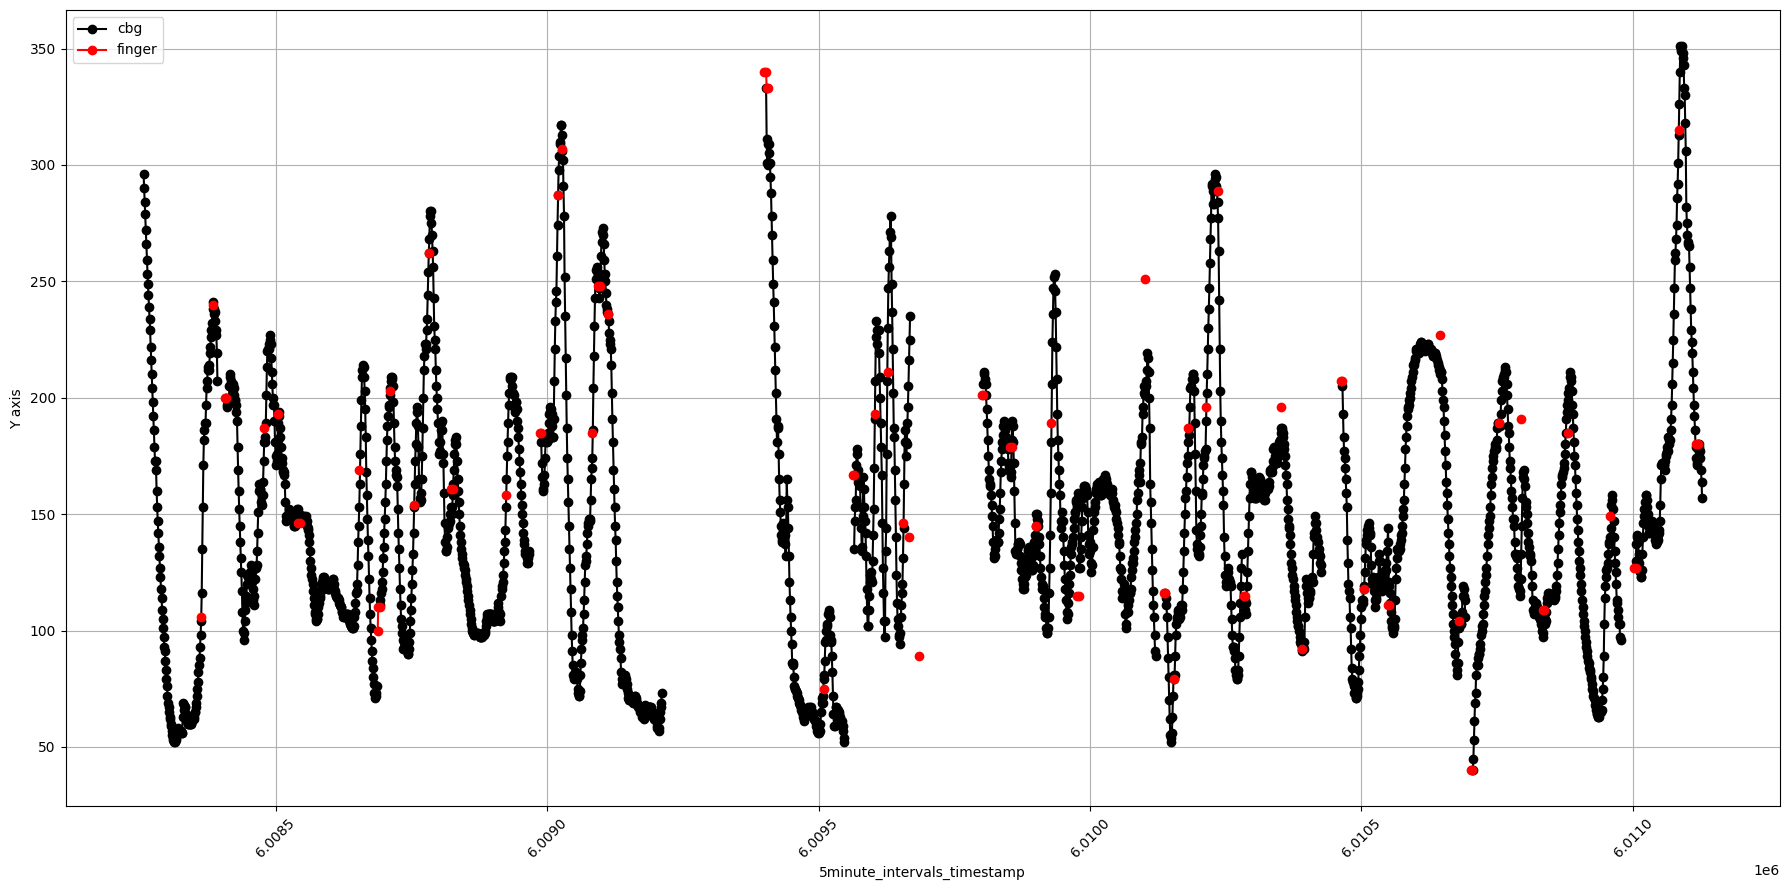

Patient:  584-ws-testing_processed.csv


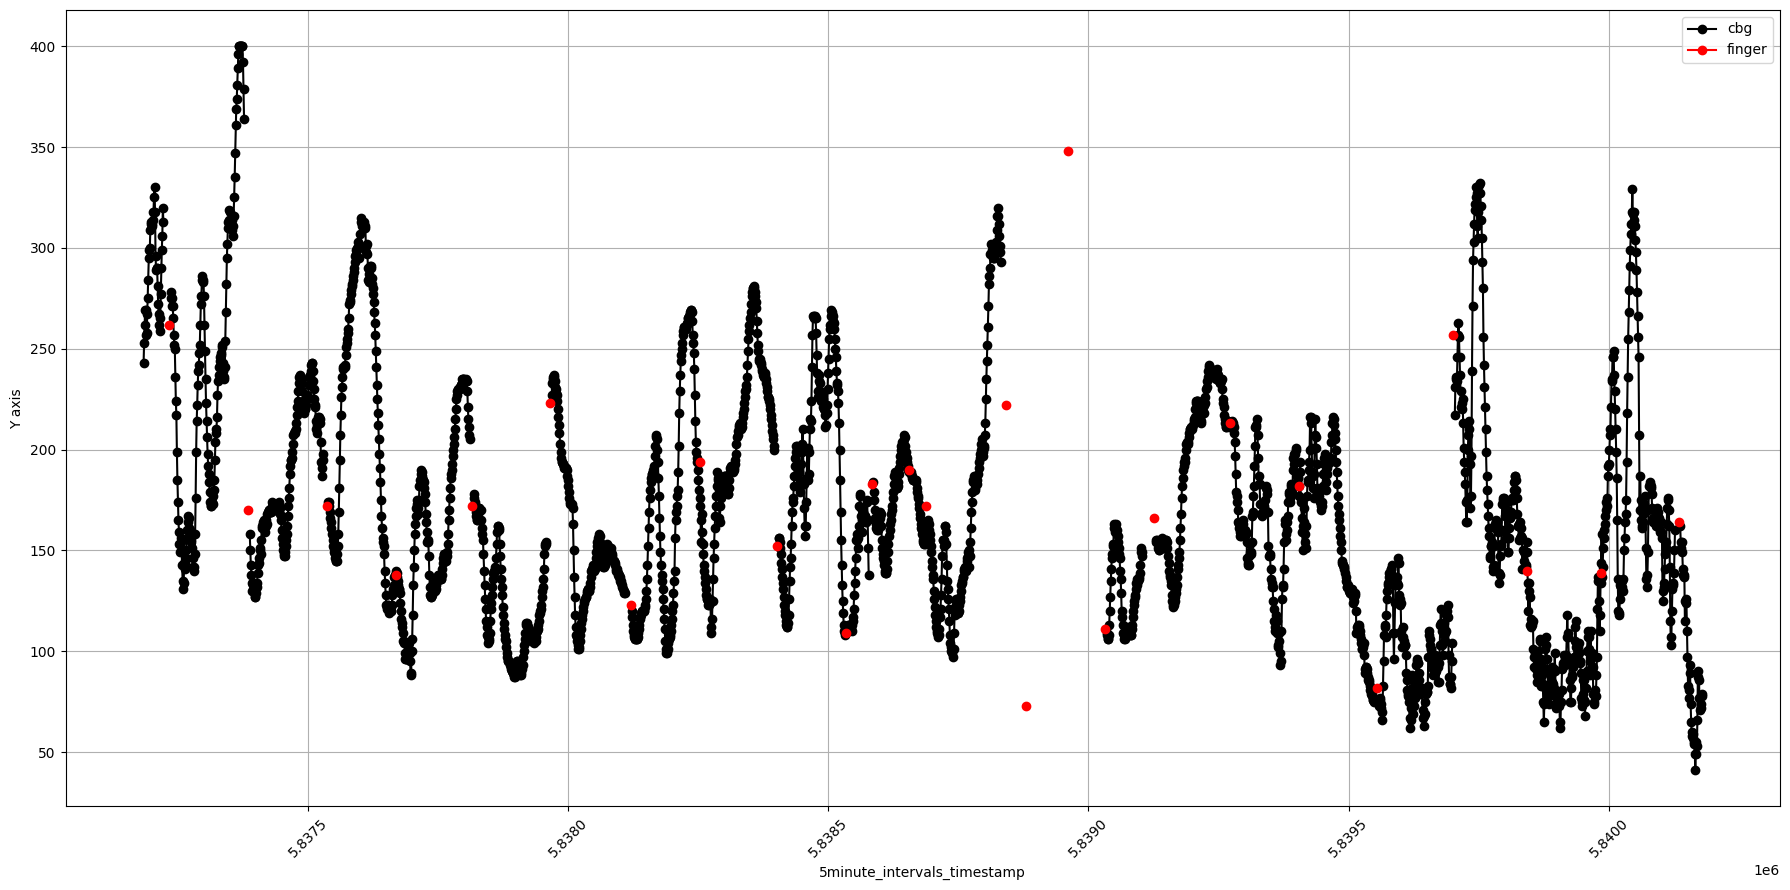

Patient:  596-ws-testing_processed.csv


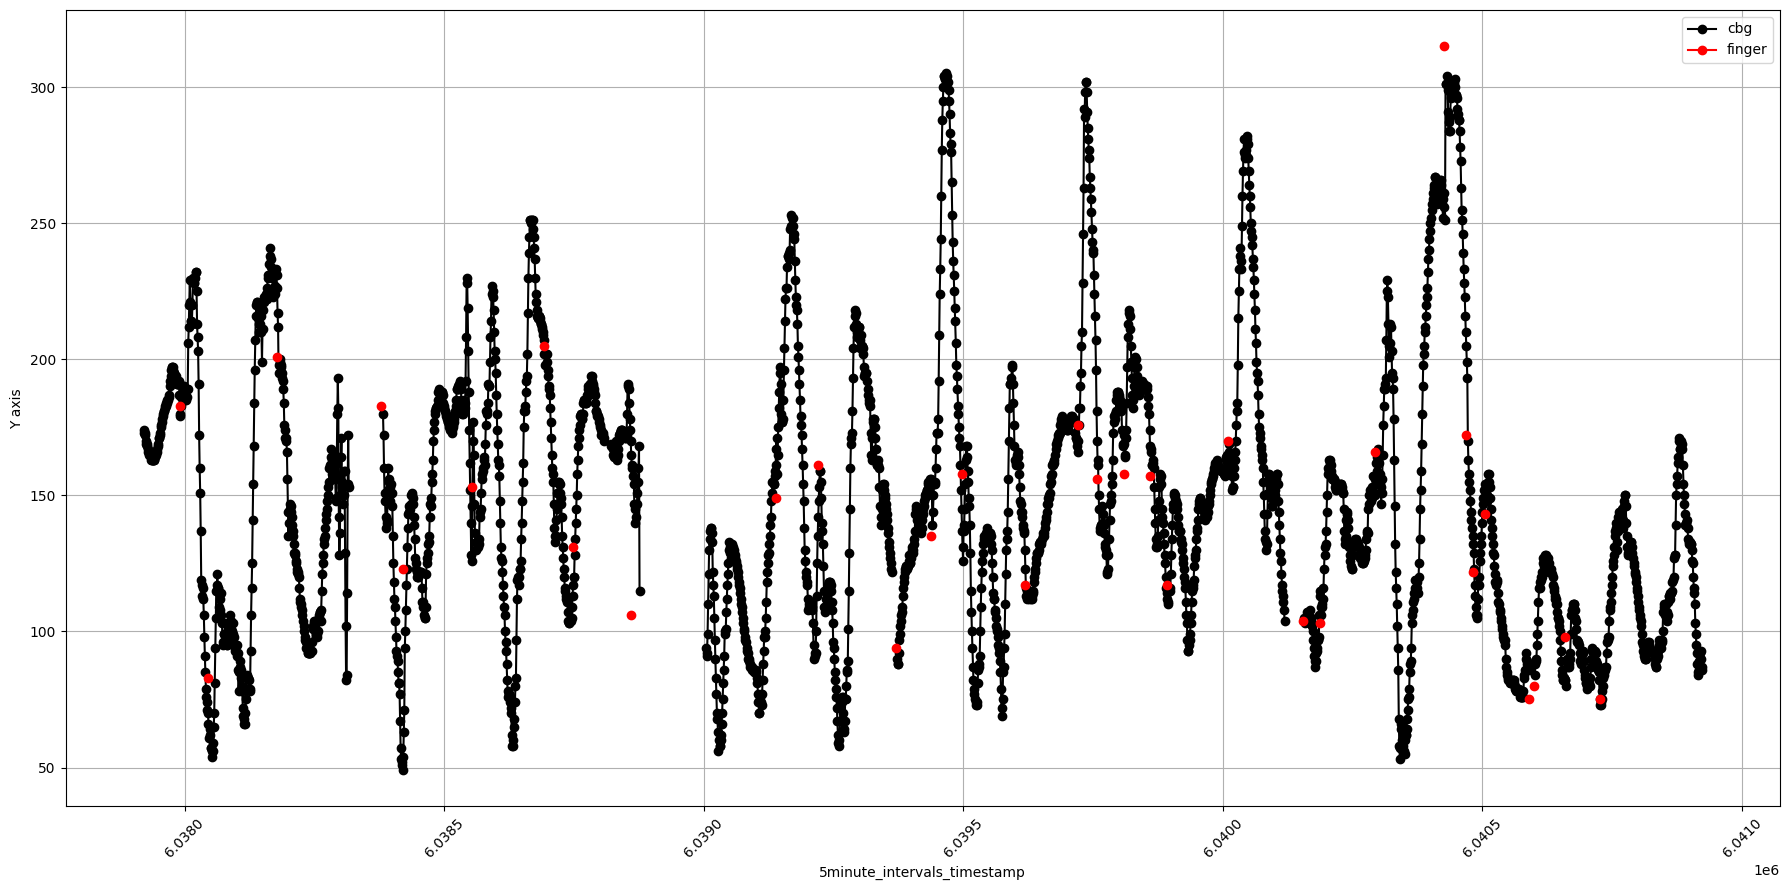

In [36]:
# Displaying all 24 plots:

# Create a dictionary
data_dict = {
    'train_set_2018': train_set_2018,
    'test_set_2018': test_set_2018,
    'train_set_2020': train_set_2020,
    'test_set_2020': test_set_2020,
}

for name, data in data_dict.items():
    print(f"Data: {name}")
    for index, value in enumerate(data):
        
        # not super pretty but it works:
        if name == 'train_set_2018':
            print("Patient: ", names_train_2018[index])
        elif name == 'test_set_2018':
            print("Patient: ", names_test_2018[index])
        elif name == 'train_set_2020':
            print("Patient: ", names_train_2020[index])
        else:
            print("Patient: ", names_test_2020[index])
                
        # Actual ploting of each of the 24 plots
        filtered_df = data[index]

        # Plot lines
        plt.figure(figsize=(18, 9))
        plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['cbg'], marker='o', linestyle='-', color='black', label='cbg')
        plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['finger'], marker='o', linestyle='-', color='red', label='finger')
        # plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['hr'], marker='o', linestyle='-', color='orange', label='hr')
        
        #TODO ADD bolus data to plot 
        
        # I multipled the basal by 100 just so its easier to see in plot
        # plt.plot(filtered_df['5minute_intervals_timestamp'], filtered_df['basal']*100, marker='o', linestyle='-', color='green', label='basal')
        
        # Variables that we can still plot and see what happens etc. -> hr, gsr, carbInput, bolus
        # What I think they mean: hr>heart rate, gsr>Galvanic skin response, carbInput -> carb in grams?, 
        # bolus> Insulin delivered to the patient, typically before a meal or when the patient is hyperglycemic.
        
        # Horizontal line representing for hyper- and hypoglycemia, maybe it helps us see 
        # hypoglycemia_threshold = 70.2  
        # plt.axhline(y=hypoglycemia_threshold, color='blue', linestyle='--', label='Hypoglycemia Threshold')
        # hyperglycemia_threshold = 180 
        # plt.axhline(y=hyperglycemia_threshold, color='blue', linestyle='--', label='Hyperglycemia Threshold')
        
        plt.xlabel('5minute_intervals_timestamp')
        plt.ylabel('Y axis')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

### Show Preprocessing

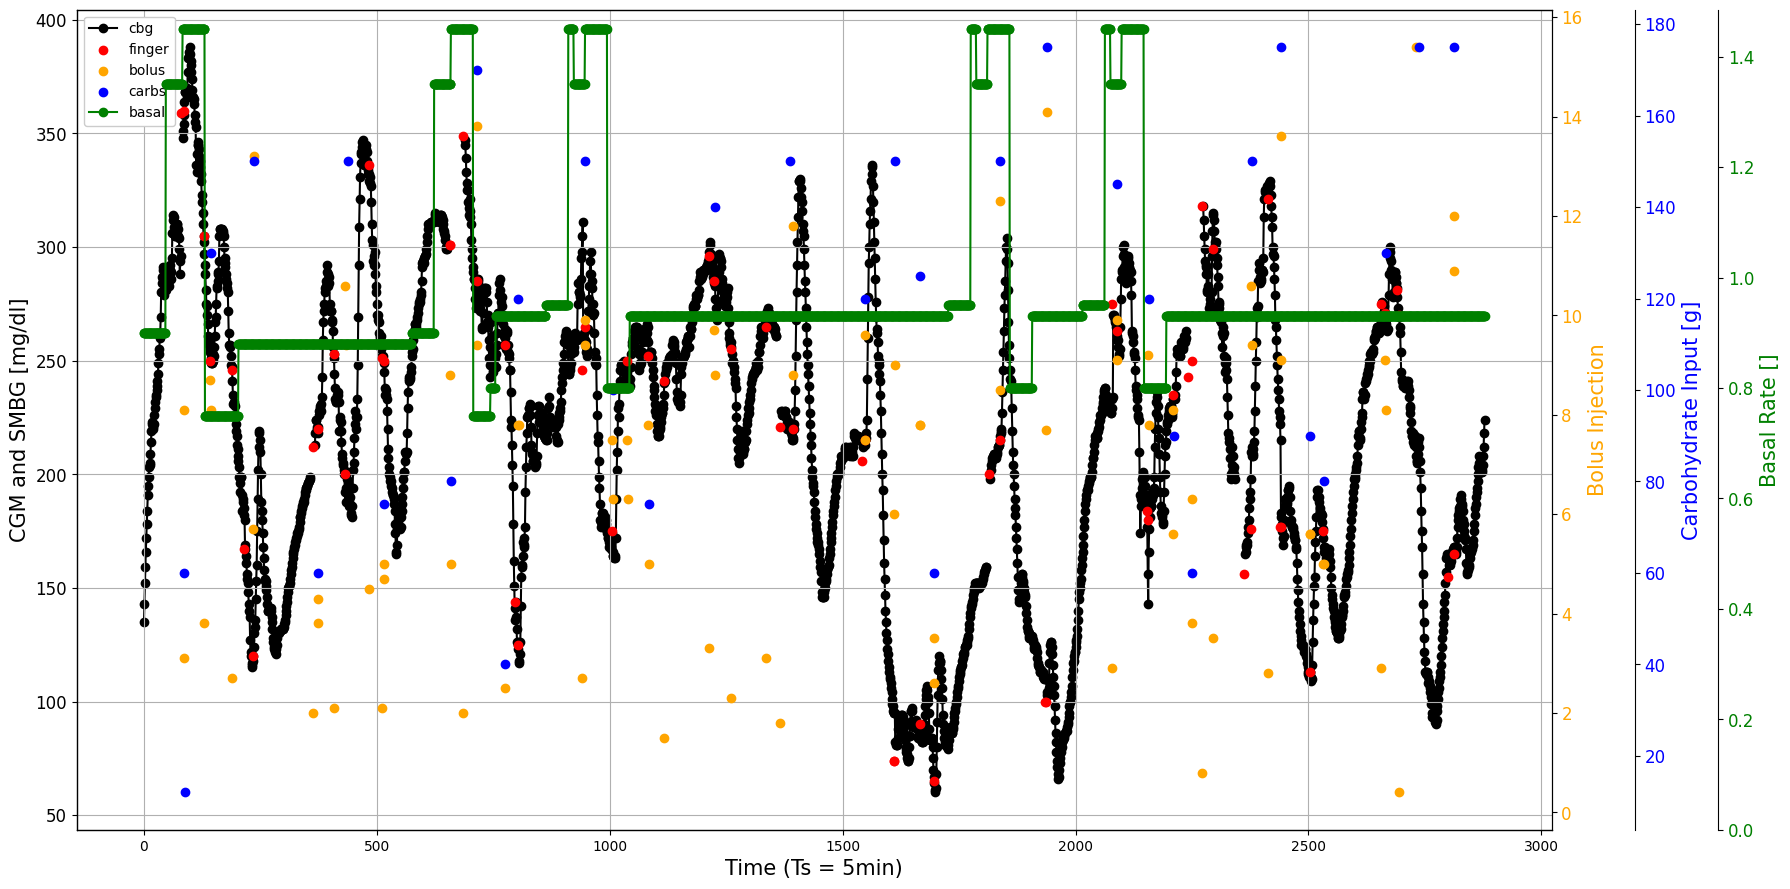

In [89]:
data = test_set_2018[2].copy()
fig, ax1 = plt.subplots(figsize=(18, 9))
plt.style.use('default') 

x = np.arange(len(data['5minute_intervals_timestamp']))

# Plot CGM and SMBG on the primary y-axis
ax1.plot(x, data['cbg'], marker='o', linestyle='-', color='black', label='cbg', zorder=1)
ax1.scatter(x, data['finger'], marker='o', linestyle='-', color='red', label='finger', zorder=5)
ax1.set_xlabel('Time (Ts = 5min)', fontsize=15)
ax1.set_ylabel('CGM and SMBG [mg/dl]', color='black', fontsize=15)
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for bolus insulin
ax2 = ax1.twinx()
ax2.scatter(x, data['bolus'], marker='o', linestyle='-', color='orange', label='bolus', zorder=2)
ax2.set_ylabel('Bolus Injection', color='orange', fontsize=15)
ax2.tick_params(axis='y', labelcolor='orange')
# ax2.legend(loc='upper right')

# Create a third y-axis for carb input
ax3 = ax1.twinx()
# Offset the third axis
ax3.spines['right'].set_position(('outward', 60))
ax3.scatter(x, data['carbInput'], marker='o', linestyle='-', color='blue', label='carbs', zorder=3)
ax3.set_ylabel('Carbohydrate Input [g]', color='blue', fontsize=15)
ax3.tick_params(axis='y', labelcolor='blue')

# Assuming you want to use the fourth y-axis for basal
ax4 = ax1.twinx()
# Offset the fourth axis
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(x, data['basal'], marker='o', linestyle='-', color='green', label='basal', zorder=4)
ax4.set_ylabel('Basal Rate []', color='green', fontsize=15)
ax4.set_ylim(0, ax4.get_ylim()[1]) 
ax4.tick_params(axis='y', labelcolor='green')

# Draw horizontal lines for thresholds
# ax1.axhline(y=hypoglycemia_threshold, color='blue', linestyle='--', label='Hypoglycemia Threshold')
# ax1.axhline(y=hyperglycemia_threshold, color='blue', linestyle='--', label='Hyperglycemia Threshold')

# This ensures all the legends are on one plot
handles, labels = [], []
for ax in fig.axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
legend = ax1.legend(handles, labels, loc='upper left', framealpha=1, facecolor='white')
legend.set_zorder(100)



# Set tick label size as well
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)
plt.xticks(rotation=45)
plt.tight_layout()  # This will adjust for the extra space needed by the additional y-axes
plt.savefig('Raw_data_patient570_notnormalized.png', dpi=300) 
plt.show()

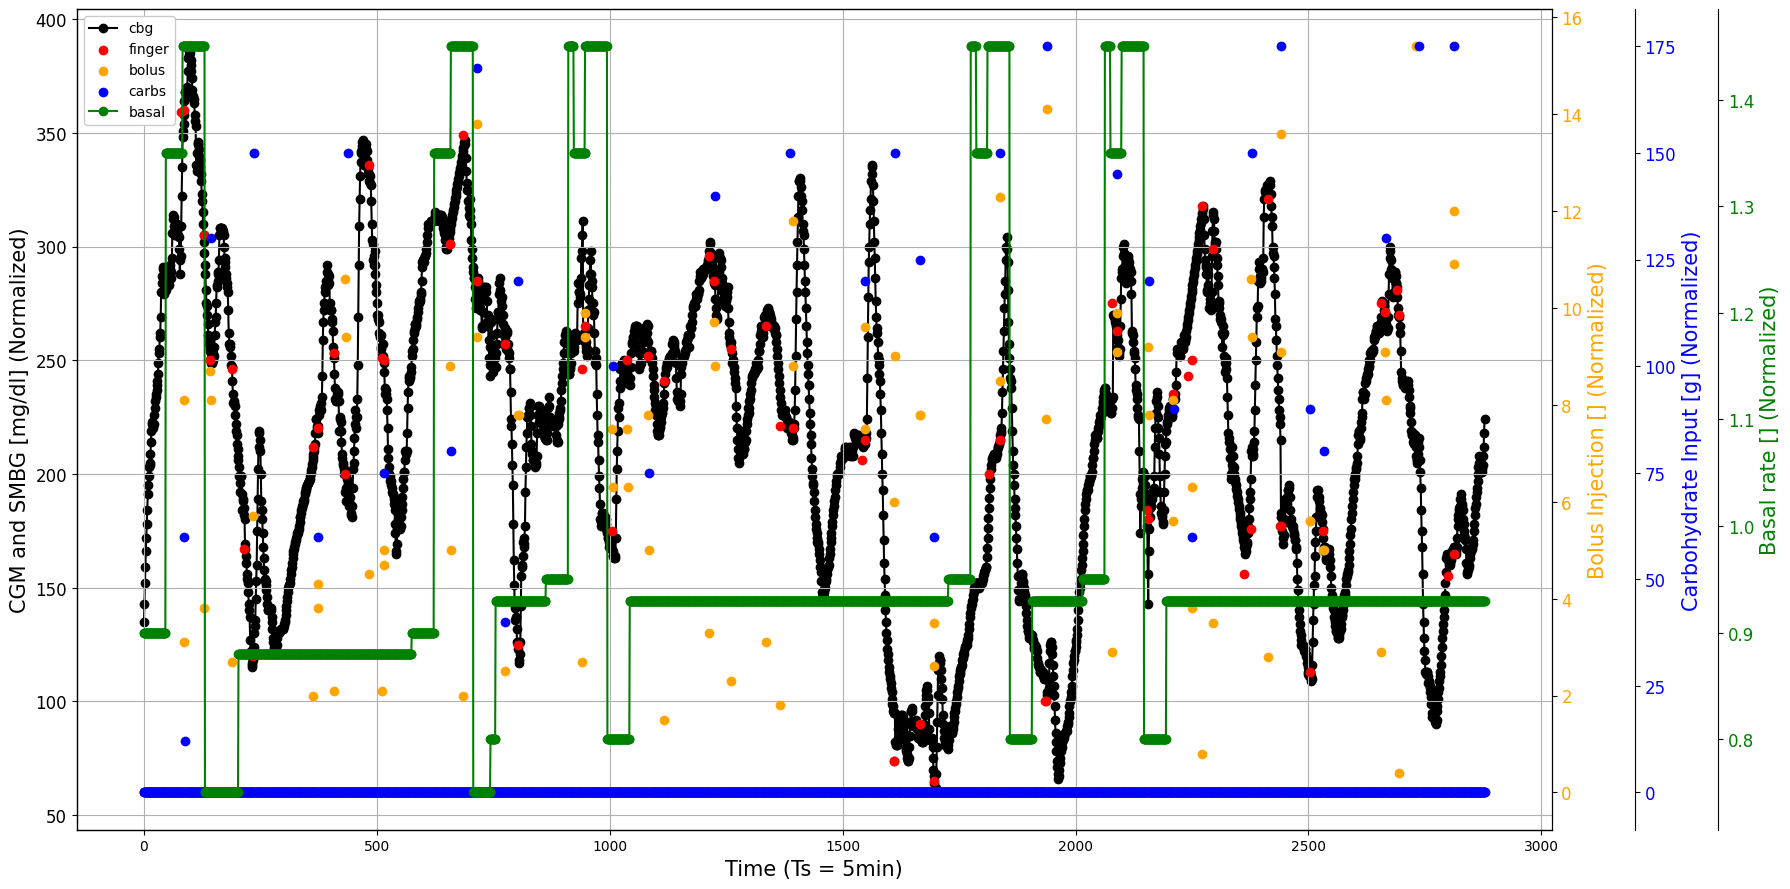

In [90]:
data = test_set_2018[2].copy()
x = np.arange(len(data['5minute_intervals_timestamp'])) # x-axis 
############################## PREPROCESSING 
# Drop the rows with large gaps in cbg in the data
max_CGM_NaN_distance = 12 * 12  # in hours*60/5 = hours*12
CGM_NaN_indices = data['cbg'][data['cbg'].isna()].index  # Identify all indices where CGM is NaN
diffs = np.diff(CGM_NaN_indices)  # Calculate the difference between two successive NaN indices
# Find where the difference between consecutive indices is greater than 1
# this indicates where a new NaN window starts
breaks = np.where(diffs > 1)[0]
to_drop_indices = []
for i in np.arange(len(breaks)):
    if i == 0:  # First NaN window
        stop_index_NaN_window = CGM_NaN_indices[breaks[i]] + 1  # + 1 because window = 0 to N = 0:N+1
        start_index_NaN_window = CGM_NaN_indices[0]
    else:  # All windows between the first and the last one
        stop_index_NaN_window = CGM_NaN_indices[breaks[i]] + 1
        start_index_NaN_window = CGM_NaN_indices[breaks[i - 1] + 1]
    # If NaN window is longer than the defined maximal window length, drop this window in the end
    if (stop_index_NaN_window - start_index_NaN_window) > max_CGM_NaN_distance:
        to_drop_indices.extend(range(start_index_NaN_window, stop_index_NaN_window))
    if i == len(breaks) - 1:  # Last NaN window (last and second last window are checked in the same loop)
        stop_index_NaN_window = CGM_NaN_indices[-1] + 1
        start_index_NaN_window = CGM_NaN_indices[breaks[i] + 1]
        if (stop_index_NaN_window - start_index_NaN_window) > max_CGM_NaN_distance:
            to_drop_indices.extend(range(start_index_NaN_window, stop_index_NaN_window))
# Drop all NaN windows which are longer than the defined maximum window length
data.drop(to_drop_indices, inplace=True)
# Reset the index of the dataframe
data.reset_index(drop=True, inplace=True)

# Interpolate the zones with missing 'cbg' so there is not regions with super steep changes
data['cbg'] = data['cbg'].interpolate(method='linear', limit_direction='both')

# Replace SMBG values where the absolute difference exceeds the threshold and SMBG is not NaN
max_bg_difference = 100
mask = ((data['finger'] - data['cbg']).abs() > max_bg_difference) & (data['finger'].notna())
data.loc[mask, 'finger'] = data.loc[mask, 'cbg']

# Replace any 0 values in 'finger' with corresponding values from 'cbg'
data.loc[data['finger'] == 0, 'finger'] = data.loc[data['finger'] == 0, 'cbg']

# Periods of no food or bolus injected
data['bolus'].fillna(0.0, inplace=True)
data['carbInput'].fillna(0.0, inplace=True)

######### SCAlING 
# Feature selection, cbg is for y_train, the rest are for x_train
# features = ['cbg', 'finger', 'basal', 'carbInput', 'bolus']

# test_set = data[features].values

# Scaling data from 0 to 1 for each individual feature
# scaled_test_set = np.zeros((test_set.shape[0], test_set.shape[1]))

# scalers_transforms_test = []


# # Loop for the test set
# for i in range(data.shape[1]):
#     # Extract the column and remember where NaNs are
#     column = data.iloc[:, i]
#     column = np.array(column)
#     isnan_mask = np.isnan(column)

#     # Replace NaN values with the mean of the non-NaN elements for scaling
#     column_mean = np.nanmean(column)
#     column[isnan_mask] = column_mean

#     # Scale the data
#     scaler = MinMaxScaler(feature_range=(0, 1))
#     scaled_column = scaler.fit_transform(column.reshape(-1, 1))

#     # We store a -1 value where there is a NaN value
#     scaled_column[isnan_mask] = 0
#     data.iloc[:,i] = scaled_column

#     # scaled_test_set[:, i] = scaled_column.flatten()

#     # scalers_transforms_test.append(scaler)

#     # column[isnan_mask] = np.nan


fig, ax1 = plt.subplots(figsize=(18, 9))
plt.style.use('default') 



# Plot CGM and SMBG on the primary y-axis
ax1.plot(x, data['cbg'], marker='o', linestyle='-', color='black', label='cbg', zorder=1)
ax1.scatter(x, data['finger'], marker='o', color='red', label='finger', zorder=5)
ax1.set_xlabel('Time (Ts = 5min)', fontsize=15)
ax1.set_ylabel('CGM and SMBG [mg/dl] (Normalized)', color='black', fontsize=15)
ax1.tick_params(axis='y', labelcolor='black')
ax1.legend(loc='upper left')
ax1.grid(True)

# Create a second y-axis for bolus insulin
ax2 = ax1.twinx()
ax2.scatter(x, data['bolus'], marker='o', linestyle='-', color='orange', label='bolus', zorder=2)
ax2.set_ylabel('Bolus Injection [] (Normalized)', color='orange', fontsize=15)
ax2.tick_params(axis='y', labelcolor='orange')
# ax2.legend(loc='upper right')

# Create a third y-axis for carb input
ax3 = ax1.twinx()
# Offset the third axis
ax3.spines['right'].set_position(('outward', 60))
ax3.scatter(x, data['carbInput'], marker='o', linestyle='-', color='blue', label='carbs', zorder=3)
ax3.set_ylabel('Carbohydrate Input [g] (Normalized)', color='blue', fontsize=15)
ax3.tick_params(axis='y', labelcolor='blue')

# Assuming you want to use the fourth y-axis for basal
ax4 = ax1.twinx()
# Offset the fourth axis
ax4.spines['right'].set_position(('outward', 120))
ax4.plot(x, data['basal'], marker='o', linestyle='-', color='green', label='basal', zorder=4)
ax4.set_ylabel('Basal rate [] (Normalized)', color='green', fontsize=15)
# ax4.set_ylim(0, ax4.get_ylim()[1]) 
ax4.tick_params(axis='y', labelcolor='green')

# Draw horizontal lines for thresholds
# ax1.axhline(y=hypoglycemia_threshold, color='blue', linestyle='--', label='Hypoglycemia Threshold')
# ax1.axhline(y=hyperglycemia_threshold, color='blue', linestyle='--', label='Hyperglycemia Threshold')

# This ensures all the legends are on one plot
handles, labels = [], []
for ax in fig.axes:
    for h, l in zip(*ax.get_legend_handles_labels()):
        handles.append(h)
        labels.append(l)
legend = ax1.legend(handles, labels, loc='upper left', framealpha=1, facecolor='white')
legend.set_zorder(100)



# Set tick label size as well
ax1.tick_params(axis='y', which='major', labelsize=12)
ax2.tick_params(axis='y', which='major', labelsize=12)
ax3.tick_params(axis='y', which='major', labelsize=12)
ax4.tick_params(axis='y', which='major', labelsize=12)

plt.xticks(rotation=45)
plt.tight_layout()  # This will adjust for the extra space needed by the additional y-axes
plt.savefig('Raw_data_patient570_normalized.png', dpi=300) 
plt.show()

# Final Implementation - Main Functions

In [10]:
def add_artificial_SMBG(data, time_between_two_SMBGs_in_h):
    """
    Add artificial SMBG values to the data so we assure we have at least a few SMBG value in the prediction window
    as some patients had sparse finger smbg tests. In the report, we tested every 2h, 4h, 8h artificial smbg added.

    :param data: data to add artificial SMBG values to
    :param time_between_two_SMBGs_in_h: maximal time window between two SMBG values
    :return: data with artificial SMBG values and the indices of the artificial SMBG values
    """

    # Convert the maximal time window between two SMBG values into number of samples
    time_step_distance = round(time_between_two_SMBGs_in_h * 12)  # hours * 60min/hour / 5min/step
    artificial_SMBG_indices = [0]

    # Get indices of available SMBG values
    SMBG_indices = data['finger'][data['finger'].notna()].index
    # Calculate the distance between two successive available values and if the distance is longer
    # than the defined maximum, insert additional artificial SMBG values
    for i in range(len(SMBG_indices)):
        if i == 0:  # first value --> distance to this value
            distance = SMBG_indices[i]
        elif i == len(SMBG_indices) - 1:  # last value --> distance to the end
            distance = data['cbg'].index[-1] - SMBG_indices[i]
        else:  # not first or last index --> distance between two successive values
            distance = SMBG_indices[i + 1] - SMBG_indices[i]
        if distance > time_step_distance:
            num_artificial_points = math.ceil(
                distance / time_step_distance) - 1  # For example: twice the distance --> add one artificial point
            if num_artificial_points > 0:
                # For each needed atrificial SMBG value, calculate the index and copy
                # the CGM value at this index
                for j in range(num_artificial_points):
                    if i == 0:
                        artificial_index = time_step_distance * (j + 1)
                    elif i == len(SMBG_indices) - 1:
                        artificial_index = SMBG_indices[i] + time_step_distance * (j + 1)
                        if artificial_index > data['cbg'].index[
                            -1]:  # check if artificial index is outside of CGM signal
                            break
                    else:
                        artificial_index = SMBG_indices[i] + time_step_distance * (j + 1)
                    data['finger'].iloc[artificial_index] = data['cbg'].iloc[artificial_index]
                    # Save artificial indices for the differentiation between artificial and real
                    # SMBG value in the result figure
                    artificial_SMBG_indices.append(artificial_index)

    # Create a first SMBG at time 0 with the value of the first CGM value
    data['finger'].iloc[0] = data['cbg'].iloc[0]
    return data, artificial_SMBG_indices

In [11]:
def preprocess_data(data, SMBG_window):
    """
    Preprocess the data - Given that there are some missing cbg values, we interpolate them only if the gap (size of
    consecutive missing values)  is not too large (greater than 12h without cbg). If the gap is too large,
    we drop the whole window and concatenate the data to avoid bug on the interpolation.

    We also replace SMBG values where the absolute difference exceeds the threshold and SMBG is not NaN. We also
    replace any 0 values in 'finger' with corresponding values from 'cbg'. Finally, we add artificial SMBG values to
    increase the frequency of the data. Additionally, we fill NaN values in 'bolus' and 'carbInput' with 0.

    :param data: data to preprocess
    :param SMBG_window: SMBG window
    :return: preprocessed data and the indices of the artificial SMBG values
    """
    # Drop the rows with large gaps in cbg in the data
    max_CGM_NaN_distance = 12 * 12  # in hours*60/5 = hours*12
    CGM_NaN_indices = data['cbg'][data['cbg'].isna()].index  # Identify all indices where CGM is NaN
    diffs = np.diff(CGM_NaN_indices)  # Calculate the difference between two successive NaN indices
    # Find where the difference between consecutive indices is greater than 1
    # this indicates where a new NaN window starts
    breaks = np.where(diffs > 1)[0]
    to_drop_indices = []
    for i in np.arange(len(breaks)):
        if i == 0:  # First NaN window
            stop_index_NaN_window = CGM_NaN_indices[breaks[i]] + 1  # + 1 because window = 0 to N = 0:N+1
            start_index_NaN_window = CGM_NaN_indices[0]
        else:  # All windows between the first and the last one
            stop_index_NaN_window = CGM_NaN_indices[breaks[i]] + 1
            start_index_NaN_window = CGM_NaN_indices[breaks[i - 1] + 1]
        # If NaN window is longer than the defined maximal window length, drop this window in the end
        if (stop_index_NaN_window - start_index_NaN_window) > max_CGM_NaN_distance:
            to_drop_indices.extend(range(start_index_NaN_window, stop_index_NaN_window))
        if i == len(breaks) - 1:  # Last NaN window (last and second last window are checked in the same loop)
            stop_index_NaN_window = CGM_NaN_indices[-1] + 1
            start_index_NaN_window = CGM_NaN_indices[breaks[i] + 1]
            if (stop_index_NaN_window - start_index_NaN_window) > max_CGM_NaN_distance:
                to_drop_indices.extend(range(start_index_NaN_window, stop_index_NaN_window))
    # Drop all NaN windows which are longer than the defined maximum window length
    data.drop(to_drop_indices, inplace=True)
    # Reset the index of the dataframe
    data.reset_index(drop=True, inplace=True)

    # Interpolate the zones with missing 'cbg' so there is not regions with super steep changes
    data['cbg'] = data['cbg'].interpolate(method='linear', limit_direction='both')

    # Replace SMBG values where the absolute difference exceeds the threshold and SMBG is not NaN
    max_bg_difference = 100
    mask = ((data['finger'] - data['cbg']).abs() > max_bg_difference) & (data['finger'].notna())
    data.loc[mask, 'finger'] = data.loc[mask, 'cbg']

    # Replace any 0 values in 'finger' with corresponding values from 'cbg'
    data.loc[data['finger'] == 0, 'finger'] = data.loc[data['finger'] == 0, 'cbg']

    # Add artificial SMBG values
    data, artificial_SMBG_indices = add_artificial_SMBG(data, SMBG_window)

    # Periods of no food or bolus injected
    data['bolus'].fillna(0.0, inplace=True)
    data['carbInput'].fillna(0.0, inplace=True)

    return data, artificial_SMBG_indices

In [13]:
def read_patient(train_set, test_set, prediction_window, SMBG_window):
    """
    Read the data of a patient and call the preprocess functions onto the train and test set. We create the arrays
    containing the features, were X has the explanatory variables ['finger', 'basal', 'carbInput', 'bolus'] and Y has
    the target variable ['cbg']. We also scale the data from 0 to 1 for each individual feature so we can train the
    model. Finally, we split the data into windows so that the model can train as expected.

    X_train = [window1, window2, ..., windowN] where window1 = [finger1, basal1, carbInput1, bolus1]
    Y_train = [window1, window2, ..., windowN] where window1 = [cbg1]

    X_train and Y_train are overlapping windows of size prediction_window. This overlapping was chosen to obtain more
    training windows for the model training.

    For the test set, X_test and Y_test are not overlapping windows of size prediction_window. This is because we want
    to predict the entire window of Y_test with the correspondent window of X_test.

    :param train_set: training set
    :param test_set: testing set
    :param prediction_window: prediction window
    :param SMBG_window: SMBG window
    :return: preprocessed data, scalers for the train and test set, and the indices of the artificial SMBG values
    """

    # Preprocess the data
    train_set, train_artificial_SMBG_indices = preprocess_data(train_set, SMBG_window)
    test_set, test_artificial_SMBG_indices = preprocess_data(test_set, SMBG_window)

    test_set_plotting = test_set  # save dataframe for the plotting of SMBG values in the results

    # Feature selection, cbg is for y_train, the rest are for x_train
    features = ['cbg', 'finger', 'basal', 'carbInput', 'bolus']
    train_set = train_set[features].values
    test_set = test_set[features].values

    # Scaling data from 0 to 1 for each individual feature
    scaled_train_set = np.zeros((train_set.shape[0], train_set.shape[1]))
    scaled_test_set = np.zeros((test_set.shape[0], test_set.shape[1]))

    scalers_transforms_train = []
    scalers_transforms_test = []

    # Loop for the train set
    for i in range(train_set.shape[1]):
        # Extract the column and remember where NaNs are
        column = train_set[:, i]
        isnan_mask = np.isnan(column)

        # Replace NaN values with the mean of the non-NaN elements for scaling
        column_mean = np.nanmean(column)
        column[isnan_mask] = column_mean

        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_column = scaler.fit_transform(column.reshape(-1, 1))

        # We store a -1 value where there is a NaN value
        scaled_column[isnan_mask] = 0  

        scaled_train_set[:, i] = scaled_column.flatten()

        scalers_transforms_train.append(scaler)

        column[isnan_mask] = np.nan

    # Loop for the test set
    for i in range(test_set.shape[1]):
        # Extract the column and remember where NaNs are
        column = test_set[:, i]
        isnan_mask = np.isnan(column)

        # Replace NaN values with the mean of the non-NaN elements for scaling
        column_mean = np.nanmean(column)
        column[isnan_mask] = column_mean

        # Scale the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_column = scaler.fit_transform(column.reshape(-1, 1))

        # We store a -1 value where there is a NaN value
        scaled_column[isnan_mask] = 0

        scaled_test_set[:, i] = scaled_column.flatten()

        scalers_transforms_test.append(scaler)

        column[isnan_mask] = np.nan

    x_train = []  # holds the features (all except cbg) with window size equal the prediction window
    y_train = []  # holds the cbg with window size equal the prediction window

    # Splitting the vector where y_train is cbg and x_train has the other features
    for i in range(prediction_window, len(scaled_train_set)):
        x_train.append(scaled_train_set[i - prediction_window:i, 1:])
        y_train.append(scaled_train_set[i - prediction_window:i,
                       0])  # to predict, 0 corresponds to 'cbg' as the prediction target

    x_train, y_train = np.array(x_train), np.array(y_train)  # converting from list to numpy array

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], len(features) - 1))  # number of windows,
    # window size, features except cbg

    # print(x_train.shape) (11531, 80, 4)
    # print(y_train.shape) (11531, 80)

    x_test = []  # arrays of blood glucose with len of input_len
    y_test = []  # arrays of blood glucose with len of output_len
    ground_truth_cbg = []  # creates a 1D ground truth vector of cgm, used for plotting only

    i = prediction_window
    while i < len(scaled_test_set):
        x_test.append(scaled_test_set[i - prediction_window:i, 1:])
        y_test.append(test_set[i - prediction_window:i, 0])
        for j in test_set[i - prediction_window:i, 0]:
            ground_truth_cbg.append(j)
        i = i + prediction_window  # jump output_len values in the future

    x_test = np.array(x_test)  # converting to numpy array
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], len(features) - 1))

    # print(x_test.shape) (35, 80, 4)
    # print(np.array(y_test).shape) (35, 80)

    return x_train, y_train, x_test, y_test, ground_truth_cbg, scalers_transforms_train, scalers_transforms_test, test_set_plotting, train_artificial_SMBG_indices, test_artificial_SMBG_indices

In [14]:
def train_model(x_train, y_train, batch_size, epochs, learning_rate):
    """
    Create and train the model
    :param x_train: training input data
    :param y_train: training target data
    :param batch_size: batch size
    :param epochs: number of epochs
    :param learning_rate: learning rate
    :return: the trained model and the history of the training

    The values printed below are only an example of the shapes of the data. Values of number of windows change
    depending on the patient being tested.

    TRAINING: To have significantly more trainings windows, we are moving the prediction window always 1 to the
    right, giving a total of 11531 windows, the prediction window size is 80 and the number of features is 4 (
    finger, basal, carbInput, bolus)
    print(x_train.shape) (11531, 80, 4)
    print(y_train.shape) (11531, 80)

    TESTING: Here we don't want to move the prediction window 1 to the right, we want to predict the entire window
    of y_test with the correspondent window of x_test. So we have 35 windows of prediction window size is 80 and
    the number of features is 4 (finger, basal, carbInput, bolus).
    print(x_test.shape) (35, 80, 4)
    print(np.array(y_test).shape) (35, 80)

    """

    prediction_window_size = x_train.shape[1]
    num_features = x_train.shape[2]  # number of features except cbg (finger, basal, carbInput, bolus)

    model = Sequential()
    model.add(
        LSTM(units=100, return_sequences=True, activation="tanh", input_shape=(prediction_window_size, num_features)))
    model.add(BatchNormalization())
    model.add(LSTM(units=100, return_sequences=False, activation="tanh"))  # We tried also Relu, but it made the
    # prediction worse
    # model.add(BatchNormalization()) # Adding batch norm here, also made prediction worse here
    model.add(Dropout(0.2))

    # Here the shape of Dense is 80 because we want to predict 80 values of cbg per X_train window
    model.add(Dense(units=y_train.shape[1]))

    custom_optimizer = Adam(learning_rate=learning_rate)

    # model.compile(optimizer="adam", loss='mse')
    model.compile(optimizer=custom_optimizer, loss='mse')

    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

    return model, history

In [15]:
def make_prediction(scalers_transforms_test, model, x_test, y_test):
    """
    Make predictions on the test set
    :param scalers_transforms_test:
    :param model:
    :param x_test:
    :param y_test:
    :return:
    """
    # Make predictions
    predictions = model.predict(x_test)
    predictions = np.reshape(predictions, (predictions.shape[0], predictions.shape[1]))  # reshape to match y_test
    predictions = scalers_transforms_test[0].inverse_transform(predictions)  # bring values back to original scale

    # Concatenate the predictions windows of size prediction_window to a single vector for plotting
    predicted_cbg = predictions[0]
    for i in range(1, len(predictions)):
        predicted_cbg = np.concatenate([predicted_cbg, predictions[i]])

    # Example shape predicted_cbg: (2800,) --> 35 windows of 80 values each

    y_test = np.array(y_test)
    # print("shape y_test:", y_test.shape)  # shape y_test: (35, 80)
    # print("shape prediction:", predictions.shape)  # shape prediction: (35, 80)

    # Calculate the RMSE
    rmse = round(np.sqrt(np.mean(((predictions - y_test) ** 2))), 4)

    return predictions, predicted_cbg, rmse

In [16]:
def create_and_save_plots(continuous_ytest, continuous_predictions, test_set_plotting, rmse, history,
                          batch_size, epochs, learning_rate, prediction_window,
                          test_artificial_SMBG_indices, inter_statement, SMBG_window, patient_index, data_from_2018):
    '''
    Create and save plots for the test set with the predicted and ground truth CBG lines, containing also the real
    and artificial SMBG values and the plot for the training loss

    :param continuous_ytest:
    :param continuous_predictions:
    :param test_set_plotting:
    :param rmse:
    :param history:
    :param batch_size:
    :param epochs:
    :param learning_rate:
    :param prediction_window:
    :param test_artificial_SMBG_indices:
    :param inter_statement:
    :return:
    '''

    patient_ids_2018 = [559, 563, 570, 575, 588, 591]
    patient_ids_2020 = [540, 544, 552, 567, 584, 596]

    if data_from_2018:
        plotted_patient_id = patient_ids_2018[patient_index]
    else:
        plotted_patient_id = patient_ids_2020[patient_index]

    # Create a directory for saving plots inside the 'results' folder
    time_stamp = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
    dir_name = f"results/plots_{time_stamp}"  # Prepend 'results/' to the directory name
    os.makedirs(dir_name, exist_ok=True)
    # Plotting the predictions
    plt.figure(figsize=(16, 8))
    plt.title(f'Blood Glucose Prediction Model Result with RMSE: {rmse} ({inter_statement}) '
              f'(Patient ID: {plotted_patient_id})')
    plt.plot(continuous_ytest, color='b')
    plt.plot(continuous_predictions, color='r')

    plt.plot(np.arange(len(test_set_plotting['finger'].iloc[:len(continuous_predictions)])),
             test_set_plotting['finger'].iloc[:len(continuous_predictions)], marker='o', linestyle='-',
             color='black')  # plot all SMBG values (artificial and real)
    test_artificial_SMBG_indices = np.array(test_artificial_SMBG_indices)
    test_artificial_SMBG_indices = test_artificial_SMBG_indices[
        test_artificial_SMBG_indices < len(continuous_predictions)]
    plt.scatter(np.arange(len(test_set_plotting['finger']))[test_artificial_SMBG_indices],
                test_set_plotting['finger'].iloc[test_artificial_SMBG_indices], marker='o', color='green', s=50,
                zorder=5)  # plot the artifical SMBG values in another color
    plt.xlabel('Timestamp', fontsize=18)
    plt.ylabel('CGM (mg/dL)', fontsize=18)
    plt.legend(['Real', 'Predictions', "Real SMBG", "Artificial SMBG"], loc='lower right')
    plt.figtext(0.5, 0.01, f"Parameters: Batch Size: {batch_size}; #Epochs: {epochs}; Learning Rate: {learning_rate};"
                           f" Maximum SMGB Distance: {SMBG_window}h; Prediction Window: {round(prediction_window * 5 / 60, 2)}h",
                ha='center')
    plt.savefig(f"{dir_name}/test_{time_stamp}.png")
    plt.close()  # Close the plot to free up memory

    # Plotting the training loss
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'])
    plt.title(f'Model Loss ({inter_statement})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train'], loc='upper right')
    plt.figtext(0.5, 0.01, f"Parameters: Batch Size: {batch_size}; #Epochs: {epochs}; Learning Rate: {learning_rate};"
                           f" Maximum SMGB Distance: {SMBG_window}h; Prediction Window: {round(prediction_window * 5 / 60, 2)}h",
                ha='center')
    plt.savefig(f"{dir_name}/loss_{time_stamp}.png")
    plt.close()  # Close the plot to free up memory

# Final Implementation - Main 

In [23]:
'''
Main function

'''
# Configuration flags
use_ubelix = False  # Set to True to run on UBELIX, set False to run locally
model_type = 'intra'  # 'inter' to train model with all patients except the test one
# 'intra', to train and test model on only one patient

patient_i = 540  # Choose a patient ID from the list below

# List of patient excel IDs in the year folders
patient_ids_2018 = [559, 563, 570, 575, 588, 591]
patient_ids_2020 = [540, 544, 552, 567, 584, 596]

# Hyperparameters:
batch_size = 150
epochs = 2
learning_rate = 0.001
prediction_window = 80
SMBG_window = 4  # in hours

# Load the dataset paths on Ubelix or Locally
current_directory = os.getcwd()
if use_ubelix:
    data_folder = os.path.join(current_directory, 'dataset')
else:
    data_folder = os.path.join(os.path.dirname(current_directory), 'dataset')

train_set_2018 = []
test_set_2018 = []
train_set_2020 = []
test_set_2020 = []

# not super pretty but works:
names_train_2018 = []
names_test_2018 = []
names_train_2020 = []
names_test_2020 = []

# For 2018 data
for patient_id in patient_ids_2018:
    for folder_type in ['training', 'testing']:
        file_name = f"{patient_id}-ws-{folder_type}_processed.csv"
        if folder_type == 'training':
            names_train_2018.append(file_name)
        else:
            names_test_2018.append(file_name)
        file_path = os.path.join(data_folder, 'Ohio2018_processed', folder_type[:-3], file_name)
        if os.path.exists(file_path):
            patient_data = pd.read_csv(file_path)
            train_set_2018.append(patient_data) if folder_type == 'training' else test_set_2018.append(patient_data)
        else:
            raise FileNotFoundError("The target directory does not exist.")

# For 2020 data
for patient_id in patient_ids_2020:
    for folder_type in ['training', 'testing']:
        file_name = f"{patient_id}-ws-{folder_type}_processed.csv"
        if folder_type == 'training':
            names_train_2020.append(file_name)
        else:
            names_test_2020.append(file_name)
        file_path = os.path.join(data_folder, 'Ohio2020_processed', folder_type[:-3], file_name)
        if os.path.exists(file_path):
            patient_data = pd.read_csv(file_path)
            train_set_2020.append(patient_data) if folder_type == 'training' else test_set_2020.append(patient_data)
        else:
            raise FileNotFoundError("The target directory does not exist.")

# To plot correlation of all patients together we need to concatenate the datasets of each patient together
all_train_2018 = pd.concat(train_set_2018, ignore_index=True)
all_test_2018 = pd.concat(test_set_2018, ignore_index=True)
all_train_2020 = pd.concat(train_set_2020, ignore_index=True)
all_test_2020 = pd.concat(test_set_2020, ignore_index=True)

all_patient_ids = [559, 563, 570, 575, 588, 591, 540, 544, 552, 567, 584, 596]

patient_index = None

# Find the index of the patient ID in the list of all patient IDs
for i, patient_number in enumerate(all_patient_ids):
    if patient_number == patient_i:
        if i < len(patient_ids_2018) - 1:
            patient_index = i
            data_from_2018 = True
        else:
            patient_index = i - len(patient_ids_2018)
            data_from_2018 = False
        break

if patient_index == None:
    raise ValueError("The patient ID is not in the dataset.")

# Get the sets for the patient under investigation
if data_from_2018:
    test_set = test_set_2018[patient_index]
else:
    test_set = test_set_2020[patient_index]

all_training_set = []

train_input_data = None
model_type_statement = None  # for the plotting of the results

if model_type == 'inter':  # Concatenate the data of all patients excluding the patient under investigation
    model_type_statement = "Inter-Patient Model"
    for i in range(len(patient_ids_2018)):
        if i != patient_index:
            all_training_set.append(
                train_set_2018[i])
            all_training_set.append(
                train_set_2020[i])
        else:
            if data_from_2018:
                all_training_set.append(
                    train_set_2020[i])
            else:
                all_training_set.append(
                    train_set_2018[i])
    train_input_data = pd.concat(all_training_set, ignore_index=True)
elif model_type == 'intra':
    model_type_statement = "Intra-Patient Model"
    if data_from_2018:
        train_input_data = train_set_2018[patient_index]
    else:
        train_input_data = train_set_2020[patient_index]
else:
    raise ValueError("The model type is not valid, please use 'intra' or 'inter'.")

# Read the data of the patient
x_train, y_train, x_test, y_test, continuous_ytest, scalers_transforms_train, scalers_transforms_test, test_set_plotting, train_artificial_SMBG_indices, test_artificial_SMBG_indices = read_patient(
    train_input_data, test_set, prediction_window, SMBG_window)

# Train the model
model, history = train_model(x_train, y_train, batch_size, epochs, learning_rate)

# Make predictions
predictions, continuous_predictions, rmse = make_prediction(scalers_transforms_test, model, x_test, y_test)

# Create and save plots
create_and_save_plots(continuous_ytest, continuous_predictions, test_set_plotting, rmse, history,
                      batch_size, epochs, learning_rate, prediction_window,
                      test_artificial_SMBG_indices, model_type_statement, SMBG_window, patient_index,
                      data_from_2018)

Epoch 1/2
85/85 [==============================] - 35s 360ms/step - loss: 0.0386
Epoch 2/2
2/2 [==============================] - 1s 32ms/step
